# Titanic: A journey through the first attempt to submit

Last update: 29 March 2017

## Description of the Kaggle challenge

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

## Objective

Predict survival of the passengers

## Kaggle specification

There is 2 datasets, Train and Test. 
The Test dataset is used for the prediction and therefore do not have Survived feature.

## Note about this notebook

The feature selection part is a demonstration of how one may do feature selection with filter, wrapper and embedded methods using mostly sk-learn. It show the first attempt to do feature selection and not the final choice that require trials of subset of features and the tuning of models for each selected subset.

The model selection part show the first attempt to run a GridSearch and the visualization of the results with learning and validation curves, you may start from that to tune the models. 

To help fellow kagglers that are starting with machine learning and statistic, I tried to incorporate some quick notes about some useful subjects like Missing Values, Feature Encoding and Dimensionality  Reduction. Here are some blogs and sites that may enable you to read about specific subjects:
* https://sebastianraschka.com/
* http://machinelearningmastery.com/start-here/
* https://www.analyticsvidhya.com/
* http://ufldl.stanford.edu/tutorial/
* http://wikistat.fr/ (french)

If you see any mistakes or imprecisions feel free to write it down in the comment section.

## Table of contents


- [Description of the data set](#Description-of-the-data-set)
- [First look at the data](#1---First-look-at-the-data)
    - [Import Libraries](#1-A-Import-Libraries)
    - [Load Data](#1-B-Load-Data)
    - [Brief summaries](#1-C-Brief-summaries)
- [Visualization Part 1](#2---Visualization-Part-1)
    - [Basic insight of the training set](#2-A-Basic-insight-of-the-training-set)
    - [Focus on the mean of survival](#2-B-Focus-on-the-mean-of-survival)
- [Feature engineering](#3---Feature-engineering)
    - [Name](#3-A-Name)
    - [Family](#3-B-Family)
    - [Cabin](#3-C-Cabin)
- [Missing Values](#4---Missing-Values)
    - [Embarked](#4-A-Embarked)
    - [Fare](#4-B-Fare)
    - [Age and creation of child feature](#4-C-Age-and-creation-of-child-feature)
- [Visualization Part 2](#5---Visualization-Part-2)
    - [Name](#5-A-Name)
    - [Family](#5-B-Family)
    - [Deck](#5-C-Deck)
    - [Child](#5-D-Child)     
    - [All features between Training and Testing set](#5-E-All-features-between-Training-and-Testing-set)
- [Features Encoding](#6---Features-Encoding)
    - [Binary encoding](#6-A-Binary-encoding)
    - [Categorical feature encoding](#6-B-Categorical-feature-encoding)
        - [Label Encoding](#Label-Encoding)
        - [One Hot Encoding](#One-Hot-Encoding)   
    - [Feature Scaling](#6-C-Feature-Scaling)
    - [Data Preparation](#6-D-Data-Preparation)
- [Features Selection](#7---Features-Selection)
    - [Filter Methods](#7-A-Filter-Methods)
        - [Quantitative Features](#Quantitative-Features)
        - [Qualitative Features](#Qualitative-Features)
        - [Correlation matrix](#Correlation-matrix)    
    - [Feature importance with embedded methods](#7-B-Feature-importance-with-embedded-methods)   
        - [Feature importance using Logistic Regression](#Feature-importance-using-Logistic-Regression) 
        - [Feature importance using Random Forest](#Feature-importance-using-Random-Forest) 
    - [First Drop](#7-C-First-Drop)
    - [Recursive feature elimination](#7-D-Recursive-feature-elimination) 
    - [Second Drop](#7-E-Second-Drop) 
- [Model Selection](#8---Models-Selection)
    - [Helper functions](#8-A-Helper-functions)
    - [Multipe Estimators](#8-B-Multipe-Estimators)
    - [SVC](#8-C-SVC)
    - [Logistic Regression](#8-D-Logistic-Regression)
    - [Random Forest Classifier](#8-E-Random-Forest-Classifier)
- [Submission](#9---Submission)

## Description of the data set

## 1 - First look at the data

[[back to top](#Table-of-contents)]

### 1-A Import Libraries

In [1]:
# Pandas
import pandas as pd

# Visualization
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', -1)  # Can create some problems but enable to read a dataframe with lots of columns
pd.set_option('display.max_rows', 100)

# Scipy
from scipy import stats

# Sklearn

    # General
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score,
                            precision_score, recall_score) 
    # Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, VotingClassifier)

# Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

### 1-B Load Data

In [2]:
# Load data
df_train=pd.read_csv("Data/Titanic/train.csv")
df_test=pd.read_csv("Data/Titanic/test.csv")

# Get a combined Dataframe 
combined = df_train.append(df_test)
combined.reset_index(inplace=True)

# For visualization
combined.loc[0:890,'Data_set'] = 'Train'
combined.loc[891:,'Data_set'] = 'Test'
#combined.loc[0:890,'Train'] = 1Train
#combined.loc[891:,'Train'] = 0
#combined.drop('index',axis=1,inplace=True)

# Get PassengerId for test and targets for training set
targets = df_train.Survived
PassengerId = df_test['PassengerId']

# Helpler function to split combined quickly
def split_train_test(combined):
    
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    train = combined.ix[0:890]
    test = combined.ix[891:]
    
    return train,test

# Take a look at the first rows
print("Training set")
display(df_train.head())
print("Testing set")
display(df_test.head())

Training set


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Testing set


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1-C Brief summaries

In [3]:
print("----------------------------------Informations for the training set----------------------------------\n")
df_train.info()
print('\nList of Null values \n\n',df_train.isnull().sum())
print("\n----------------------------------Informations for the testing set ----------------------------------\n")
df_test.info()
print('\nList of Null values \n\n',df_test.isnull().sum())

----------------------------------Informations for the training set----------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

List of Null values 

 PassengerId    0  
Survived       0  
Pclass         0  
Name           0  
Sex            0  
Age            177
SibSp          0  
Parch          0  
Ticket         0  
Fare           0  
Cabin          687
Embarked       2  
dtype: int64

----------------------------------Informations

Observations:
* No Survived feature on the testing set
* Lot of Ages values are missing 
* Cabin feature is mostly null 
* Embarked feature has a few missing values
* Survived and Pclass should be treated as object for the next steps
* The training set is approximately twice the size of the testing set

In [4]:
# Basic statistical information about quantitative and qualitative features

# Changing the type of Pclass and Survived 
df_train['Pclass']=df_train['Pclass'].astype(object)
df_train['Survived']=df_train['Survived'].astype(object)
df_test['Pclass']=df_test['Pclass'].astype(object)

print("----------------------------------Informations for the training set----------------------------------\n")

# Quantitative
display(df_train.describe())

# Qualitative
display(df_train.describe(include=['object']))

print("----------------------------------Informations for the testing set----------------------------------\n")

# Quantitative
display(df_test.describe())

# Qualitative
display(df_test.describe(include=['object']))

----------------------------------Informations for the training set----------------------------------



,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


,Survived,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891,204,889
unique,2,3,891,2,681,147,3
top,0,3,"Chapman, Mr. John Henry",male,1601,C23 C25 C27,S
freq,549,491,1,577,7,4,644


----------------------------------Informations for the testing set----------------------------------



,PassengerId,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,30.272590,0.447368,0.392344,35.627188
std,120.810458,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,76.000000,8.000000,9.000000,512.329200


,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,418,91,418
unique,3,418,2,363,76,3
top,3,"Birnbaum, Mr. Jakob",male,PC 17608,B57 B59 B63 B66,S
freq,218,1,266,5,3,270


Observations:

* From the description of the data we know that 1502 out of 2224 people died. The global survival rate being around 32.5 %. However, in the training set the survival rate is around 38.3 %
* For the others quantitative and qualitative features for a quick look the training and testing set seem well stratified 


Quantitative
* Age:  Most people (68%) were between 16 and 44 years old
* Sibsp and Parch: Most people were traveling without parents, children, sibling or spouse.
* Fare: The fare has a really high std compare to its mean.

Qualitative
* Name: is unique for every passenger
* Sex: Around 64 % were male in both datasets
* Pclass: Little bit more than half passengers were from the 3rd class
* Embarked: Most came from Southampton (64.5% for testing and 72.2% for training)
* Ticket and Cabin: are not unique for every passenger

##  2 - Visualization Part 1

[[back to top](#Table-of-contents)]

### 2-A Basic insight of the training set

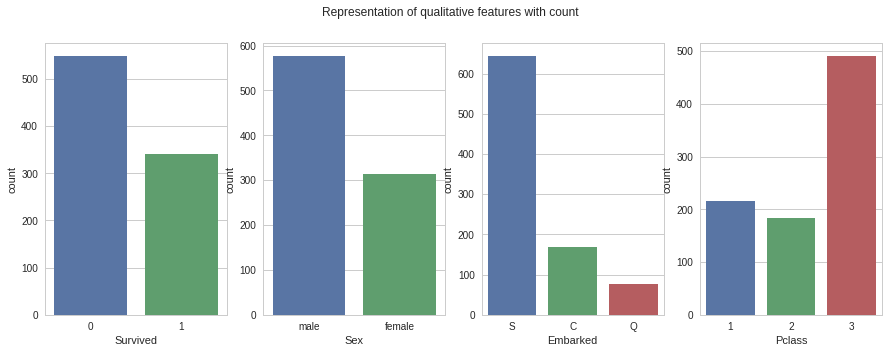

In [5]:
# Qualitative Data : [Survived, Sex, Embarked, Pclass] 
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(15,5))
sns.countplot(x='Survived', data=df_train, ax=axis1)
sns.countplot(x='Sex', data=df_train, ax=axis2)
sns.countplot(x='Embarked', data=df_train, ax=axis3)
sns.countplot(x='Pclass', data=df_train, ax=axis4)
fig.suptitle("Representation of qualitative features with count")

Observations:
* High imbalance between the values of the Survived, Sex, Plass and Embarked
* Survived and Sex count look like the same, with female being the ones that survived.
* Pclass: Pclass 1 and 2 are balanced but Pclass3 is more than half passenger
* Embarked: Most people come from Southampton and Cherbourg is twice big as Queenstown

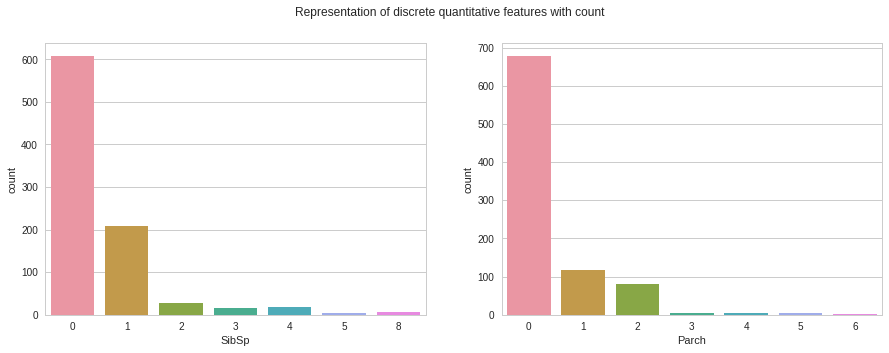

In [6]:
# Discrete Quantitative Data : [SibSp, Parch] 
fig2, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(df_train['SibSp'],ax=axis1)
sns.countplot(df_train['Parch'],ax=axis2)
fig2.suptitle("Representation of discrete quantitative features with count")

Observations:
* Passenger were mostly alone or with 1 or 2 people.

/home/jules/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


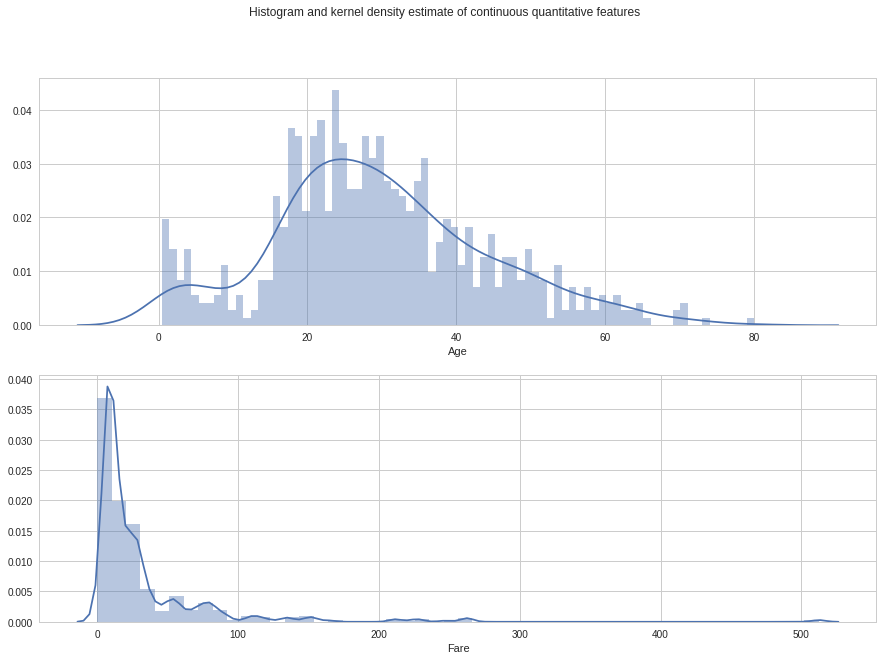

In [7]:
# Continuous Quantitative Data : [Age, Fare]
fig3, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))
sns.distplot(df_train['Age'].dropna(), bins=80, ax=axis1)
sns.distplot(df_train['Fare'], ax=axis2)
fig3.suptitle("Histogram and kernel density estimate of continuous quantitative features")

Observations:
* There is a bump representing Child in the Age distribution
* A few peoples paid way more than the others

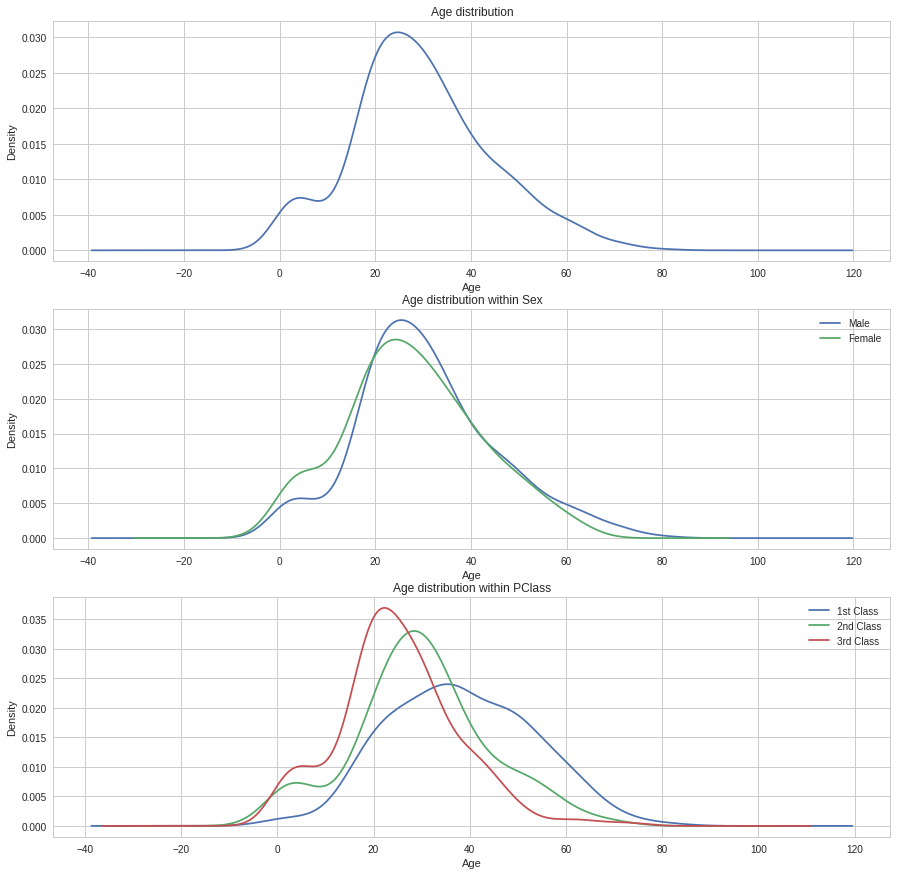

In [8]:
# Age distribution within Sex and Pclass
fig3, ((axis1),(axis2),(axis3)) = plt.subplots(3,1,figsize=(15,15))

# Age distribution
df_train.Age.plot(kind='kde',ax=axis1)
axis1.set_xlabel("Age")    
axis1.set_title("Age distribution")

# Age distribution within Sex
df_train.Age[df_train.Sex == 'male'].plot(kind='kde',ax=axis2,)    
df_train.Age[df_train.Sex == 'female'].plot(kind='kde',ax=axis2)
axis2.set_xlabel("Age")    
axis2.set_title("Age distribution within Sex")
axis2.legend(('Male', 'Female'))

# Age distribution within Pclass
df_train.Age[df_train.Pclass == 1].plot(kind='kde',ax=axis3)    
df_train.Age[df_train.Pclass == 2].plot(kind='kde',ax=axis3)
df_train.Age[df_train.Pclass == 3].plot(kind='kde',ax=axis3)
axis3.set_xlabel("Age")    
axis3.set_title("Age distribution within PClass")
axis3.legend(('1st Class', '2nd Class','3rd Class'))

Observations:
* Small differences of distribution of Age between Male and Female. Female having a higher density for child and lower for elderly.
* Significant differences of distribution of Age between Pclass 1, 2 and 3. Pclass 3 being the younger then come Pclass 2 and then Pclass 1

### 2-B Focus on the mean of survival

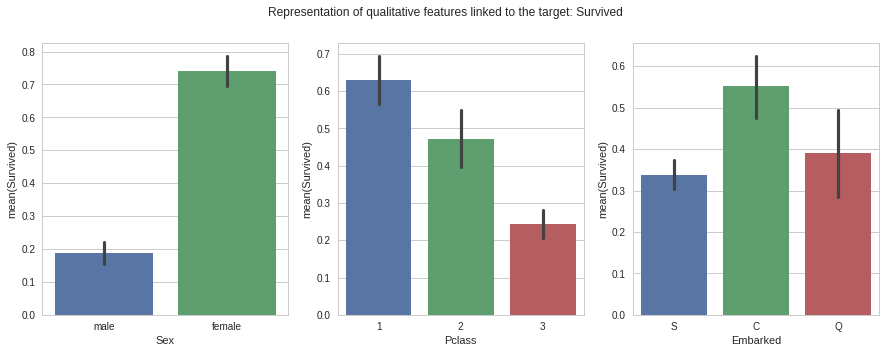

In [9]:
# (Sex, Pclass, Embarked) by mean of survival
fig4, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.barplot(x='Sex',y='Survived', data=df_train, ax=axis1)
sns.barplot(x='Embarked',y='Survived', data=df_train, ax=axis3)
sns.barplot(x='Pclass',y='Survived', data=df_train, ax=axis2)
fig4.suptitle("Representation of qualitative features linked to the target: Survived ")

Observations:
* Sex:
    * Male: low rate of survival ~0.2
    * Female: high rate of survival ~0.75
* Pclass by mean of survival 1 > 2 > 3
* Embarked: Differences of survival C > Q > S . Most people came from S so it's normal that their rate of survival is close to the global rate. 

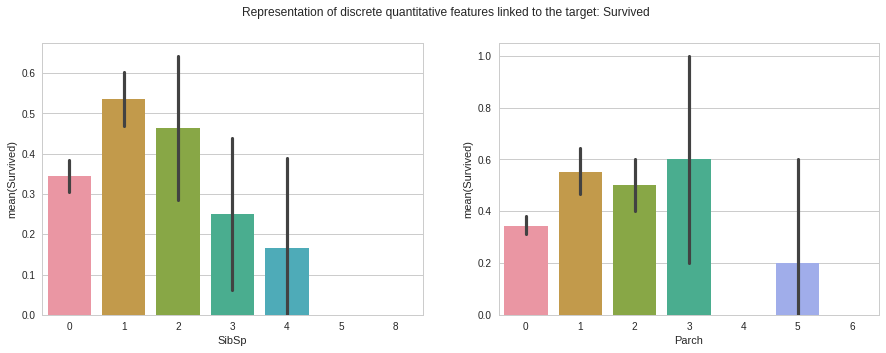

In [10]:
# (SibSp, Parch) by mean of survival
fig6, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='SibSp',y='Survived', data=df_train, ax=axis1)
sns.barplot(x='Parch',y='Survived', data=df_train, ax=axis2)
fig6.suptitle("Representation of discrete quantitative features linked to the target: Survived ")

Observations :
* Parch seems to have small differences of rate for the most encountered values. But 0 still get a lower rate. 
* Sibsp seems better and we can group them together for create a new feature showing the number of relatives (even if a lot of them are not counted in this both features, for more information you can go to the data description with this link:
  [Description](#Description-of-the-data-set)
    


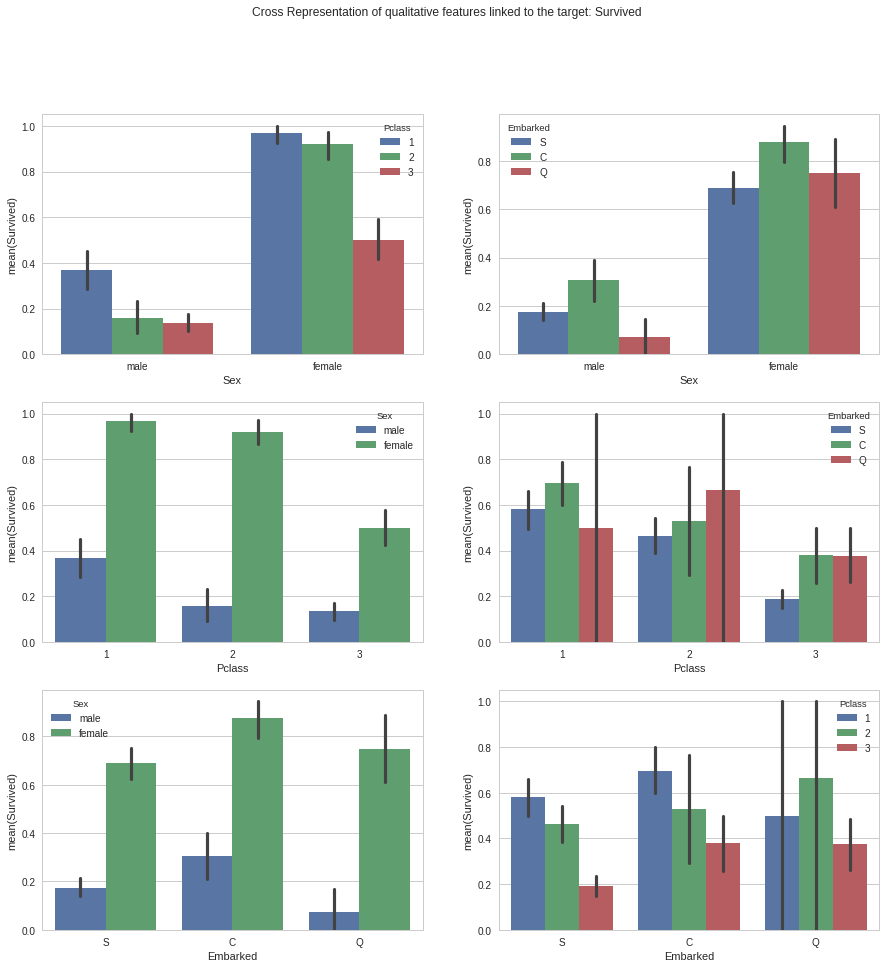

In [11]:
# Cross relation betwen (Sex, Pclass, Embarked) by mean of survival
fig5, ((axis1,axis2),(axis3,axis4),(axis5,axis6)) = plt.subplots(3,2,figsize=(15,15))
sns.barplot(x='Sex',y='Survived',hue='Pclass', data=df_train, ax=axis1)
sns.barplot(x='Sex',y='Survived',hue='Embarked', data=df_train, ax=axis2)

sns.barplot(x='Pclass',y='Survived',hue='Sex', data=df_train, ax=axis3)
sns.barplot(x='Pclass',y='Survived',hue='Embarked', data=df_train, ax=axis4)

sns.barplot(x='Embarked',y='Survived',hue='Sex', data=df_train, ax=axis5)
sns.barplot(x='Embarked',y='Survived',hue='Pclass', data=df_train, ax=axis6)

fig5.suptitle("Cross Representation of qualitative features linked to the target: Survived")

Observations:
* Male Pclass 1 has around twice the rate of male from Pclass 2 and 3
* Female class 3 has a rate around twice lower than female from Pclass 1 and 2
* Embarked do not seems very meaningful for us, but Pclass 3 Embarked from S is really lower than the others 3nd Pclass and male from Embarked Q lower than male from Embarked S and C

In [12]:
# Age

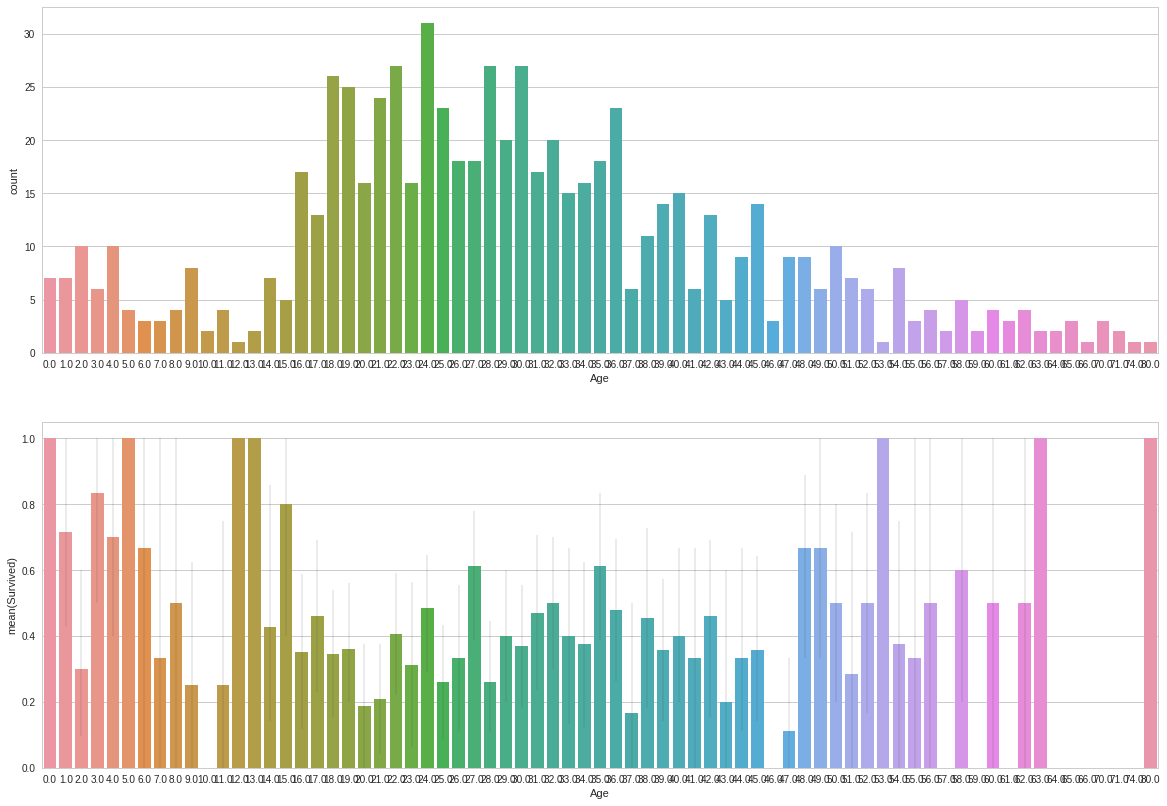

In [13]:
# Age Count and by mean of survival
df_train['Age'] = df_train['Age'].map(lambda s : s if np.isnan(s) else int(s))
fig6, (axis1,axis2) = plt.subplots(2,1,figsize=(20,14))
sns.countplot(x='Age', data=df_train,ax=axis1)
sns.barplot(x='Age', y='Survived', data=df_train,errwidth=0.2,ax=axis2)

Observations:
* Age by mean of survival is high from child and elderly and low for medium ages, following the opposite of the distribution of Age

/home/jules/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


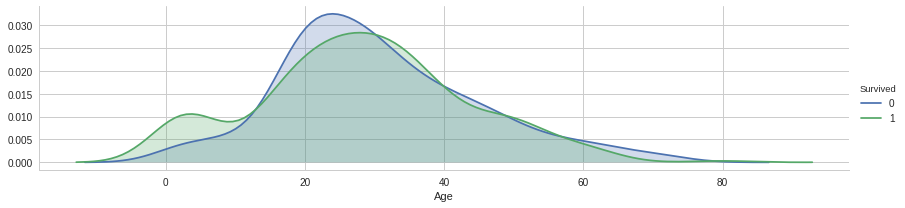

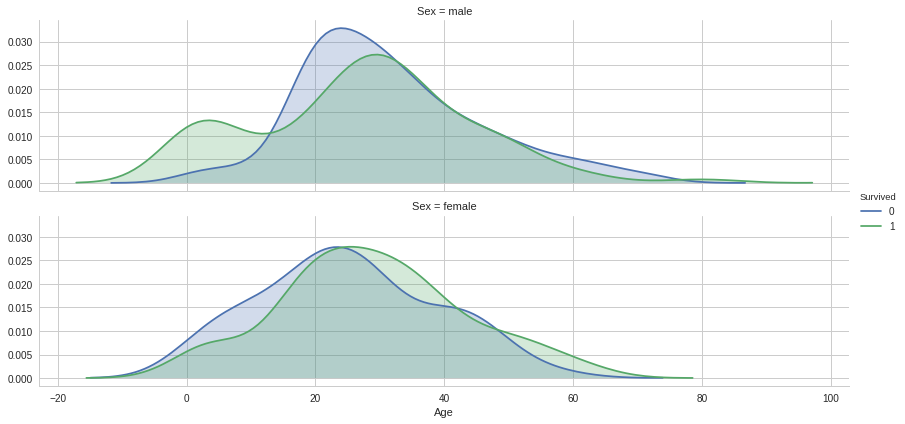

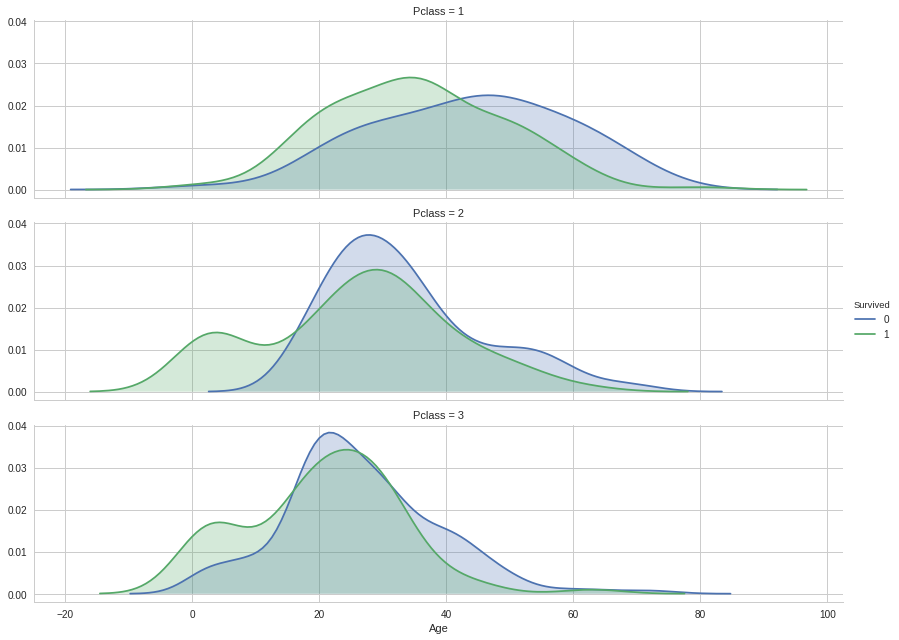

In [14]:
# Kernel density of survivor and non survivor by Age
g1 = sns.FacetGrid( df_train , hue='Survived' , aspect=4)
g1.map( sns.kdeplot , 'Age' , shade= True )
g1.add_legend()

# Kernel density of survivor and non survivor by Age and Sex 
g2 = sns.FacetGrid( df_train , hue='Survived' , aspect=4 , row = 'Sex')
g2.map( sns.kdeplot , 'Age' , shade= True )
g2.add_legend()

# Kernel density of survivor and non survivor by Age and Pclass
g3 = sns.FacetGrid( df_train , hue='Survived' , aspect=4 , row = 'Pclass')
g3.map( sns.kdeplot , 'Age' , shade= True )
g3.add_legend()

Observations:
* For the males from around 15 to 30 the rate of survival is lower, and for young boy is bigger. 
* For young females from 0 to 20 were more likely to die than the ones from 30 to 60.
* In Pclass 1 there is a separation around 40 years old, before they were more likely to survive and after to die.
* In Pclass 2 and 3 there is no clear separation but the child were more likely to survive and the older more likely to die.
* Thinking about the creation of a feature for Child as the distribution show good survival rate for young passengers. Need to check if the Training and Test dataset have the same distribution of Age.

In [15]:
# Fare

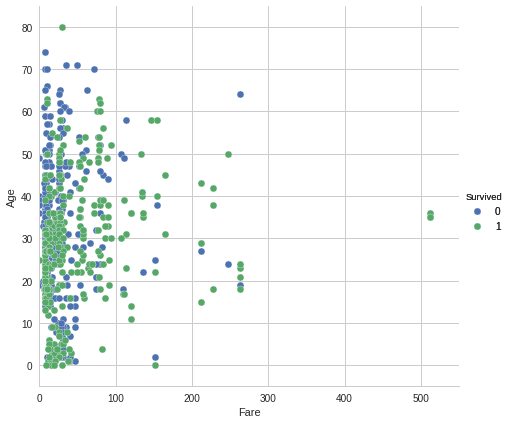

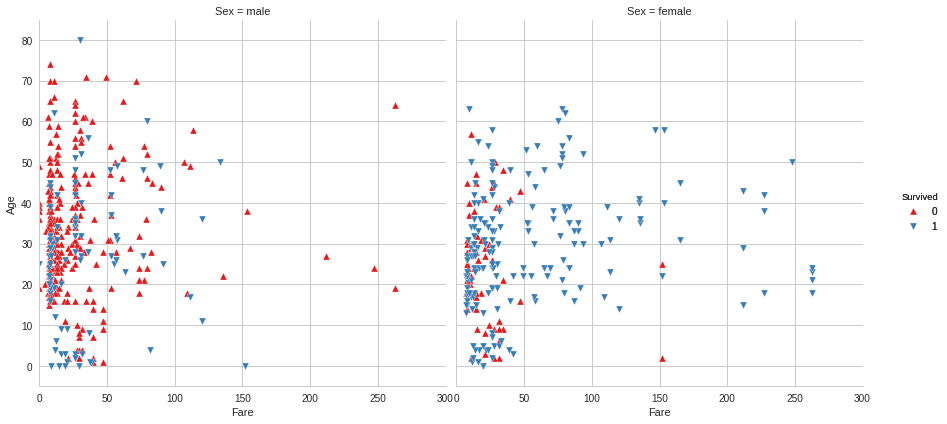

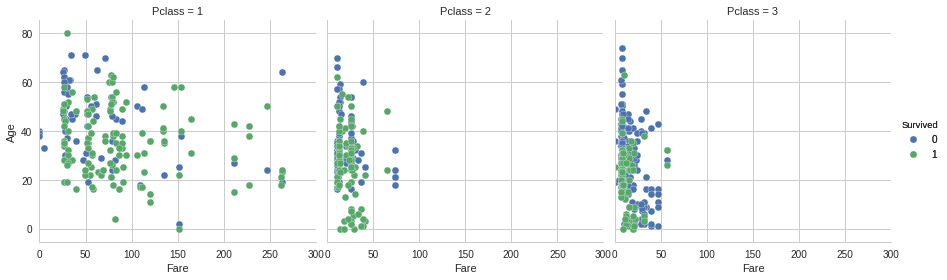

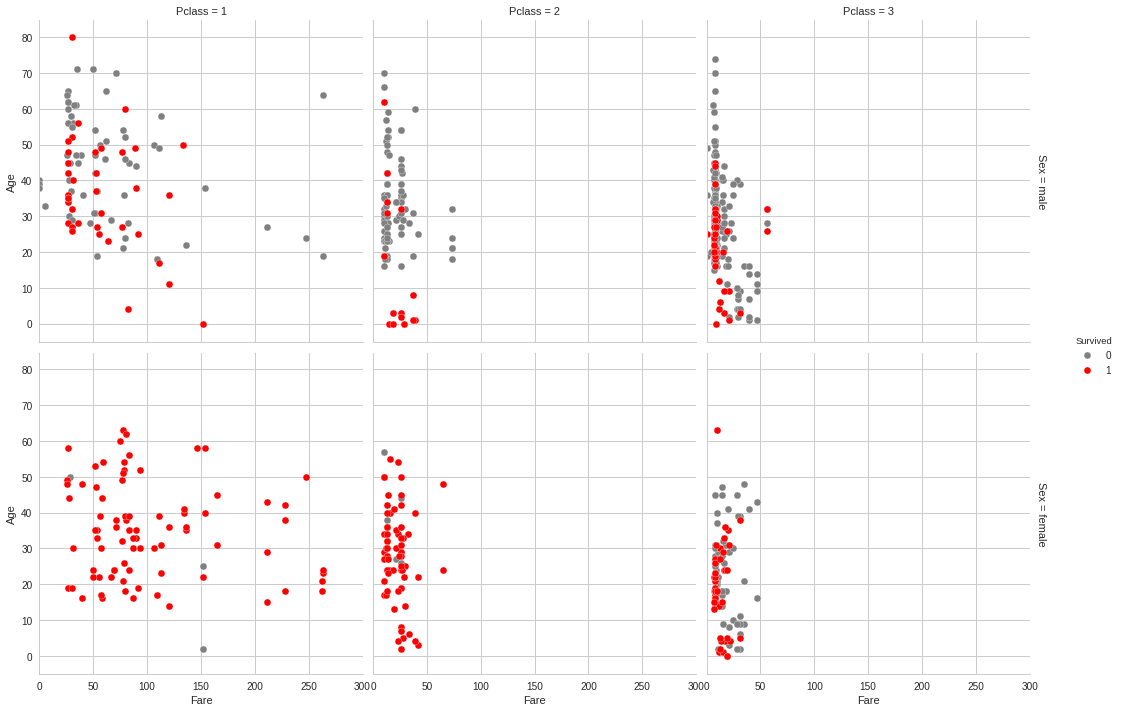

In [16]:
# Scatterplot Fare & Age
g = sns.FacetGrid(df_train, hue="Survived", size=6)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g.add_legend()
g.set(xlim=(0, 550))

# Scatterplot Fare & Age by Sex
g = sns.FacetGrid(df_train, hue="Survived", col="Sex", margin_titles=True,
                palette="Set1",hue_kws=dict(marker=["^", "v"]),size=6)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g.add_legend()
g.set(xlim=(0, 300))

# Scatterplot Fare & Age by Pclass
g = sns.FacetGrid(df_train, col="Pclass", hue="Survived", size=4)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g.add_legend()
g.set(xlim=(0, 300))

# Scatterplot Fare & Age by Pclass & Sex
g = sns.FacetGrid(df_train, hue="Survived", col="Pclass", row="Sex" ,margin_titles=True,
                  palette={1:"red", 0:"grey"},size=5)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g.set(xlim=(0, 300))

Observations:
* Female with Fare more than 50 are really likely to survive
* In Pclass 1 Fare more than 100 show a good increase of the rate but is made mostly by Female

## 3 - Feature engineering

[[back to top](#Table-of-contents)]

The visualization concerning the feature engineering is in the section [Visualization Part 2](#5---Visualization-Part-2)

### 3-A Name

Creation of 4 features:
* Name_Length = The number of letters of the full name
* Name_Size = The categorized size: Short, Medium, Long and Very Long
* Title = The extracted title of the passenger
* Title_aggr = The aggregation of the less encountered values

In [17]:
#Create feature for the length of name 
combined["Name_Length"] = combined["Name"].apply(lambda x: len(x))

# Create a categorical feature Name_Size
combined['Name_Size']=pd.cut(combined['Name_Length']
                            ,bins=[0,20,40,60,90]
                            ,labels=["Short","Medium","Long","Very Long"])

# Extract the title from each name by sliding between the ',' and the '.' 
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())

# Map for aggregated titles
Title_Dictionary = {
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "Master" :    "Master",
                    "Lady" :      "Royalty",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dona":       "Royalty",
                    "the Countess":"Royalty"
                    }
    
# Mapping
combined['Title_aggr'] = combined.Title.map(Title_Dictionary)

### 3-B Family

Creation of 2 features:
* Number of relatives = SibSp + Parch
* Size_Family =  The categorised size : Alone, Small and Big

In [18]:
# Creation of a feature Number_of_relatives = SibSp + Parch
combined['Number_of_relatives']=combined['SibSp']+combined['Parch']

# Creation of a categorical feature Size_Family
combined.loc[combined['Number_of_relatives'] == 0, 'Size_Family'] = 'Alone'
combined.loc[ (combined['Number_of_relatives'] > 0) 
            & (combined['Number_of_relatives'] < 4), 'Size_Family'] = 'Small'
combined.loc[combined['Number_of_relatives'] > 3, 'Size_Family'] = 'Big'

### 3-C Cabin

Creation of the Deck feature by extraction of the cabin number

In [19]:
# Mostly NaN values
print('Number of null values:')
display(combined.Cabin.isnull().sum())

# Create a category Unknown
combined['Cabin'] = combined.Cabin.fillna( 'U' )

# Get the Deck 
combined["Deck"]=combined.Cabin.str[0]

Number of null values:


1014

## 4 - Missing Values

[[back to top](#Table-of-contents)]

Fare and Embarked have only 1 and 2 missing values so there is two main choice either to delete or to input some values.

Age could require a more complex approach as there is a lot of missing values, for example based on prediction model.

I took the choice to go with imputation based on multivariate analysis for the three features.

**_Note about: Missing values_**

Many algorithms cannot deal with missing values like distance measure-dependent algorithms, and real world data tends to have a lot of missing values, it's therefore recommended to study the reasons before making any choice. 

The three major problems of missing data are:
* Biased results
* Decreased statistical power
* Complicated analyses

-----------------------------------------------------------------------------------------------------------

There are different assumptions about missing data mechanisms [Rubin (1976)]:

Let Ycom denote the complete data and partition it as Ycom = (Yobs, Ymis), where Yobs and Ymis are the observed and missing parts, respectively.

* **Missing At Random** (MAR)
Missing data is defined to be MAR if the distribution of missingness does not depend on Ymis. In other words, MAR allows the probabilities of missingness to depend on observed data Yobs but not on missing data Ymis.
Missing value can depends on Yobs, but not Ymis.
    
* **Missing Completely At Random** (MCAR)
An important special case of MAR, called missing completely at random (MCAR), occurs when the distribution does not depend on Yobs either. Meaning that the probabilities of missingness is unrelated to the values of any variables, whether missing or observed.
Missing value neither depends on Yobs, nor Ymis.

* **Missing Not At Random** (MNAR)
When MAR assumption is violated and the distribution depends on Ymis, the missing data are said to be missing not at random (MNAR). The probability of a missing value depends on the variable that is missing.
Missing value depends on Ymis.

MAR is also called ignorable nonresponse, and MNAR is called nonignorable [Little and Rubin 2002]. MNAR is called “non-ignorable” because the missing data mechanism itself has to be modeled as you deal with the missing data. In the MAR and MCAR mechanisms, imputation do not require that we make specific assumptions about how data are missing.

Many missing data methods assume MCAR or MAR but data often are MNAR.
Some MAR analysis methods using MNAR data are still pretty good for example Maximum Likelihood (ML) and Multiple imputation (MI) are often unbiased with NMAR data even though assume data is MAR [Schafer & Graham 2002]

In most data sets, more than one feature will have missing data, and they may not all have the same mechanism for missing data. It’s recommended to study the mechanism for each variable with missing data before choosing an approach.

-----------------------------------------------------------------------------------------------------------
Some of the classical methods to treat missing values:

**Deletion**: Deletion of row or feature

* Complete case deletion also called Listwise deletion  

    The entire row is excluded from the dataset if any single values is missing.      
Row deletion methods are used when the percentage of missing data is not so high and the missing data is assume to be “Missing completely at random”. If data is MCAR then complete case deletion does not add any bias, but it does decrease the power of the analysis by decreasing the effective sample size. 


* Feature deletion

    The entire feature that contains too many missing values is excluded.
For example used when a significant number of values are missing and you don't want to add bias/lower variance with imputation techniques or are unable to predict reasonably well this feature with the non-missing ones. 
       
**Single Imputation**: Substitute each missing value for a reasonable guess

 A Limitations of imputation techniques in general are that they lead to an underestimation of standard errors and, thus, overestimation of test statistics.
 
* Univariate and multivariate analysis
    * Univariate:
        * Missing values are imputed based on values from the same variable
    * Multivariate:
        * Missing values are imputed based on values of other variables from the same row.
    * Example:
        * Mean - For normally distributed quantitative data that is assume to be distributed similarly to the non-missing values. Note that univariate mean imputation attenuates any correlations involving the imputed variables and biased estimates of variances and covariances.
        * Median - For non-normaly distributed or discrete quantitative data or to ease outliers
        * Most frequent value - For nominal and ordinal      


* Constant

    When the features are missing for some reason that should be reflected by their value.


* Prediction model

    A machine learning or statistical predictor is used with the non-missing values features to guess the missing values. Some examples are regression, logistic regression and others. The disadvantages are that the model estimated values are usually better-behaved than the true values and if there is no relationship with others non-missing features then the estimation will not be precise.


* Knn imputation

    Knn imputation has the advantages to handle both qualitative and quantitative features. Moreover the data structure is taken into consideration as similarity of two features is determined using a distance function. Nonetheless, the choice of the k-value is critical and classical Knn is very time-consuming in analyzing large database. High k-value may include non significant features and low may miss some-significant ones.


* Binary variable 

    Create a dummy to specify that this values was missing. This helping analysis or model prediction to understand that there is a difference between missing and non-missing data. Moreover, it can enable you to analyze correlation between missing values from different features.  


**Some Advanced methods**:
* Multiple imputation] (MI)
* Maximum Likelihood (ML)
* Expectation-maximization (EM)
* SVM with kernel functions that can handle missing data
* Hot deck

### 4-A Embarked

Displaying the missing values and replacing them by looking at the boxplot of Embarked and Pclass with Fare. This assume that the location where people embarked is related to the fare they paid and the Pclass they chose.

,Fare,Pclass,Embarked
61,80.0,1,NaN
829,80.0,1,NaN


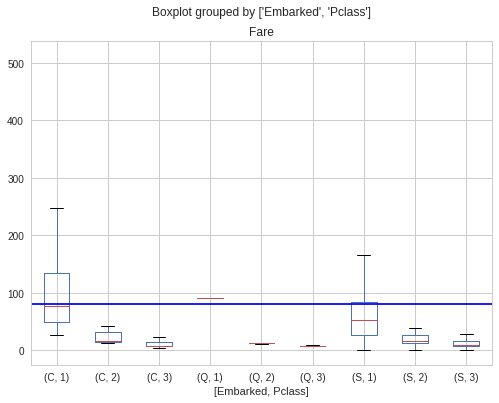

In [20]:
# Get and display the rows where Embarked is null
display(combined[combined.Embarked.isnull()][['Fare', 'Pclass', 'Embarked']])

# Display boxplot of Embarked missing values
combined.boxplot(column='Fare', by=['Embarked','Pclass'], figsize=(8,6))
plt.axhline(y=80, color='blue')

# Remplace null values by C as most people who are Pclass 1 and Fare 80 has Embarked from C
combined = combined.set_value(combined.Embarked.isnull(), 'Embarked', 'C')

### 4-B Fare

Displaying the missing values and replacing them by the mean of Fare for the same Pclass and Embarked. This assume the same assumption that for Embarked.

,Pclass,Fare,Embarked
1043,3,NaN,S


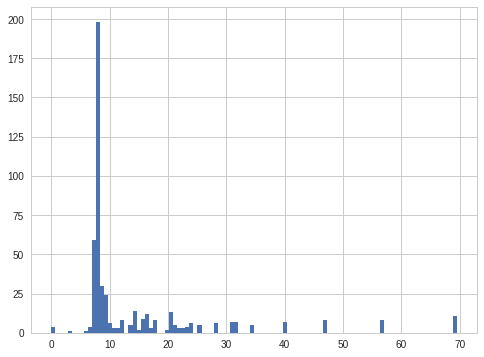

In [21]:
# Visualization of the fare which is missing
display(combined[combined.Fare.isnull()][['Pclass', 'Fare', 'Embarked']])
combined.loc[(combined['Pclass']==3) & (combined['Embarked']=='S')].Fare.hist(bins=100,figsize=(8,6))

# Get and affect the median to the missing value
Fare_median=combined[(combined.Pclass==3) & (combined.Embarked=='S')].Fare.median()
combined["Fare"].fillna(Fare_median, inplace=True)

### 4-C Age and creation of child feature

Filling Age by taking the mean of a group by with Sex, Pclass and Title_aggr. This assume that the distribution of age is related to the Sex, the Pclass and the title. 

In [22]:
# Fill the NaN values with median using Sex, Pclass and Title
grouped = combined.groupby(['Sex','Pclass','Title_aggr'])
age_mean = grouped['Age'].mean()
combined["Age"] = combined.groupby(['Sex','Pclass','Title_aggr'])['Age'].transform(lambda x: x.fillna(x.mean()))
combined.Age = combined.Age.astype(int)

# Display the median by Sex Pclass and Title_aggr
display(age_mean)

Sex     Pclass  Title_aggr
female  1       Miss          30.131148
                Mrs           42.926471
                Officer       49.000000
                Royalty       40.000000
        2       Miss          20.717083
                Mrs           33.418182
        3       Miss          17.360874
                Mrs           32.326531
male    1       Master        6.984000 
                Mr            41.450758
                Officer       51.090909
                Royalty       42.333333
        2       Master        2.757273 
                Mr            32.346715
                Officer       40.700000
        3       Master        6.090000 
                Mr            28.318910
Name: Age, dtype: float64

/home/jules/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


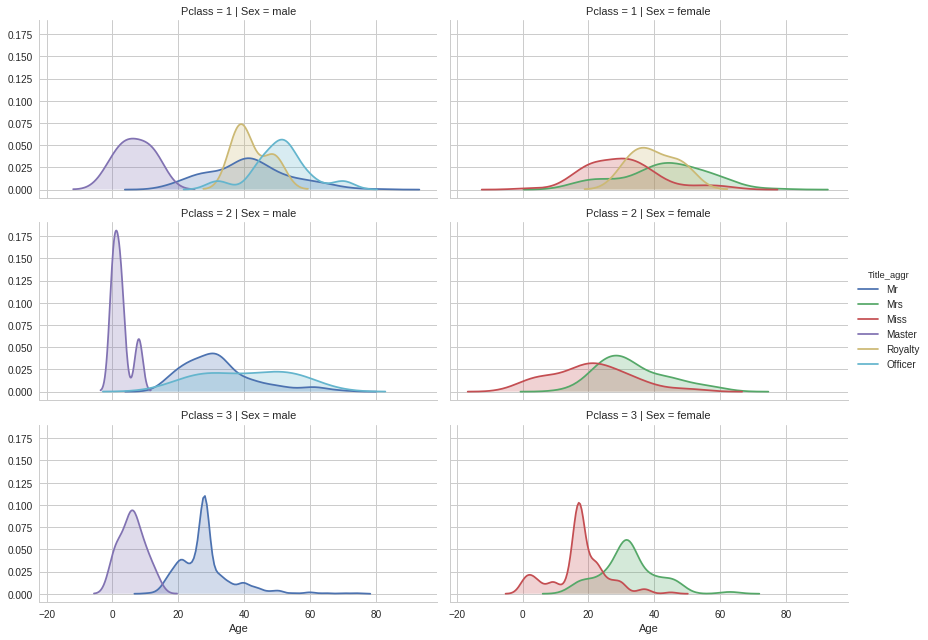

In [23]:
# Kernel density of Age by Pclass, Sex and Title_aggr
g1 = sns.FacetGrid( combined , row='Pclass' ,col='Sex',hue='Title_aggr', aspect=2)
g1.map( sns.kdeplot , 'Age' , shade= True )
g1.add_legend()

Creation of a Child feature representing passengers younger than 7

In [24]:
# Creation of a Child feature
combined['Child'] = combined['Age'].map(lambda s : 1 if s < 7 else 0)

## 5 - Visualization Part 2

[[back to top](#Table-of-contents)]

This part of the visualization treats new features created during feature engineering

In [25]:
# Verification of missing values
print('Number of null values :')
display(combined.isnull().sum())

# Split for visualization
df_train, df_test= split_train_test(combined)

# Display shape
display(df_train.shape)
display(df_test.shape)

# Name of columns
display(df_train.columns)

Number of null values :


index                  0  
Age                    0  
Cabin                  0  
Embarked               0  
Fare                   0  
Name                   0  
Parch                  0  
PassengerId            0  
Pclass                 0  
Sex                    0  
SibSp                  0  
Survived               418
Ticket                 0  
Data_set               0  
Name_Length            0  
Name_Size              0  
Title                  0  
Title_aggr             0  
Number_of_relatives    0  
Size_Family            0  
Deck                   0  
Child                  0  
dtype: int64

(891, 22)

(418, 22)

Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch',
       'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Data_set', 'Name_Length', 'Name_Size', 'Title', 'Title_aggr',
       'Number_of_relatives', 'Size_Family', 'Deck', 'Child'],
      dtype='object')

### 5-A Name

/home/jules/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


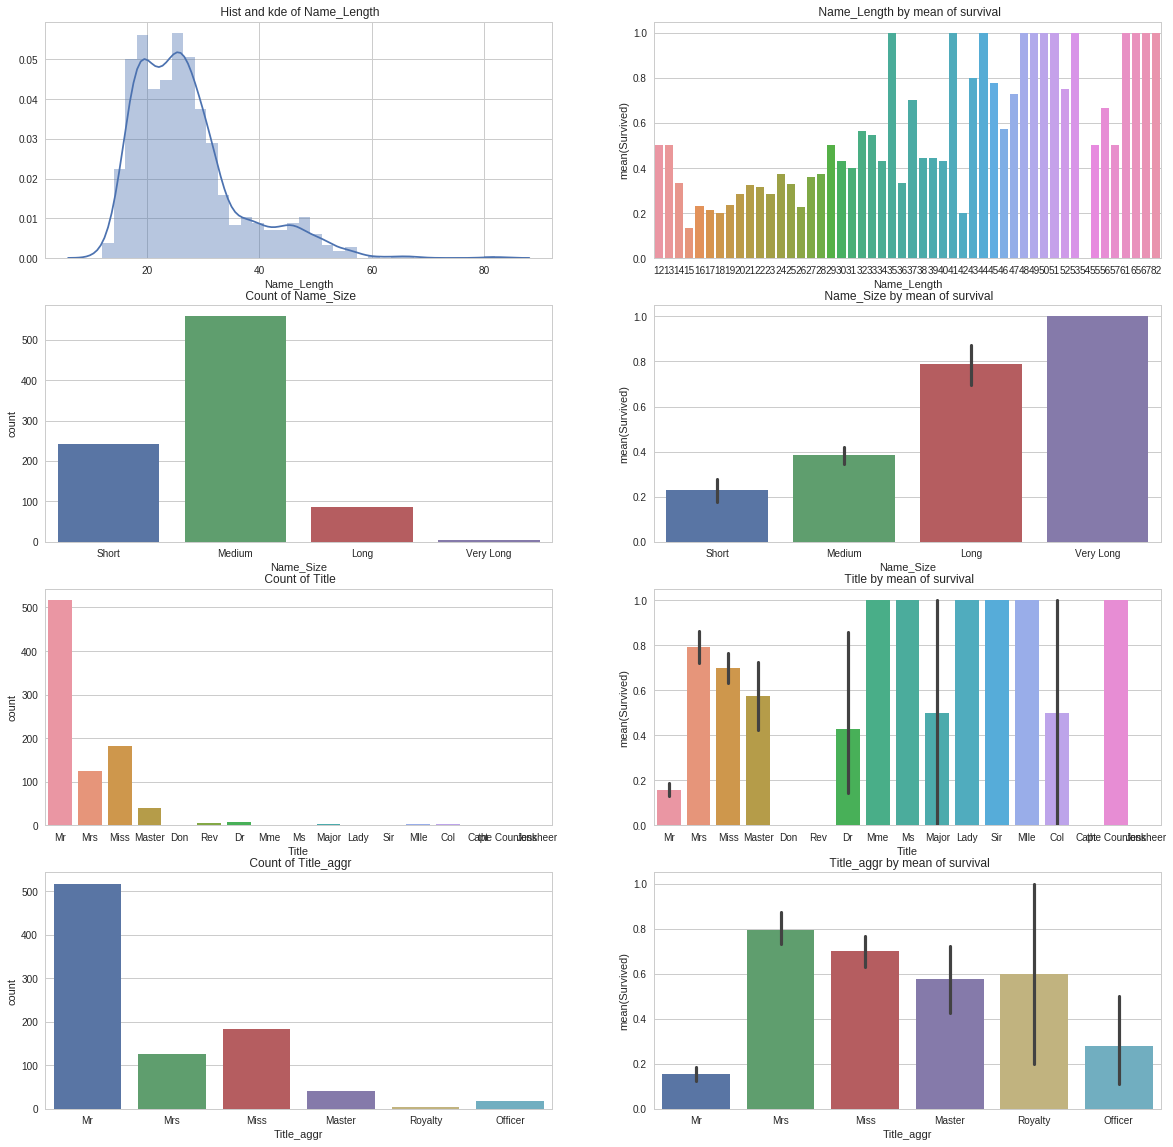

In [26]:
fig, ((axis1,axis2),(axis3,axis4),(axis5,axis6),(axis7,axis8)) = plt.subplots(4,2,figsize=(20,20))

# Plot Name_Length
sns.distplot(df_train['Name_Length'],ax=axis1)
axis1.set_title(" Hist and kde of Name_Length")
# Plot Name_Length by mean of survival
sns.barplot(x='Name_Length', y='Survived', data=df_train,errwidth=0,ax=axis2)
axis2.set_title(" Name_Length by mean of survival")

# Plot Name_Size
sns.countplot(x='Name_Size', data=df_train, order=["Short","Medium","Long","Very Long"], ax=axis3)
axis3.set_title(" Count of Name_Size")
# Plot Name_Size by mean of survival
sns.barplot(x='Name_Size',y='Survived', data=df_train, order=["Short","Medium","Long","Very Long"], ax=axis4)
axis4.set_title(" Name_Size by mean of survival")

# Plot Title
sns.countplot(x='Title', data=df_train, ax=axis5)
axis5.set_title(" Count of Title")
# Plot Title
sns.barplot(x='Title',y='Survived', data=df_train, ax=axis6)
axis6.set_title(" Title by mean of survival")

# Plot Title aggregate
sns.countplot(x='Title_aggr', data=df_train, ax=axis7)
axis7.set_title(" Count of Title_aggr")
# Plot Title aggregate
sns.barplot(x='Title_aggr',y='Survived', data=df_train, ax=axis8)
axis8.set_title(" Title_aggr by mean of survival")

# Display Title aggregate and Name Size by mean of survival
#sns.barplot(x='Title_aggr',y='Survived', hue='Name_Size', data=df_train,errwidth=1)

Observations:
* Name_Length has a big density between 15 and 35 and decrease after a small bump
* Name_Length by mean of survival increase with Name_Length
* Name_Size is mostly composed of Medium than Short.
* Name_Size by mean of survival increase with Name_Size
* Title mostly composed of Mr, Mrs, Miss and Master
* Title by mean of survival is low for Mr and high for Female and Master
* Title_aggr aggreate all the small features of Title into Royality and Officer 

### 5-B Family

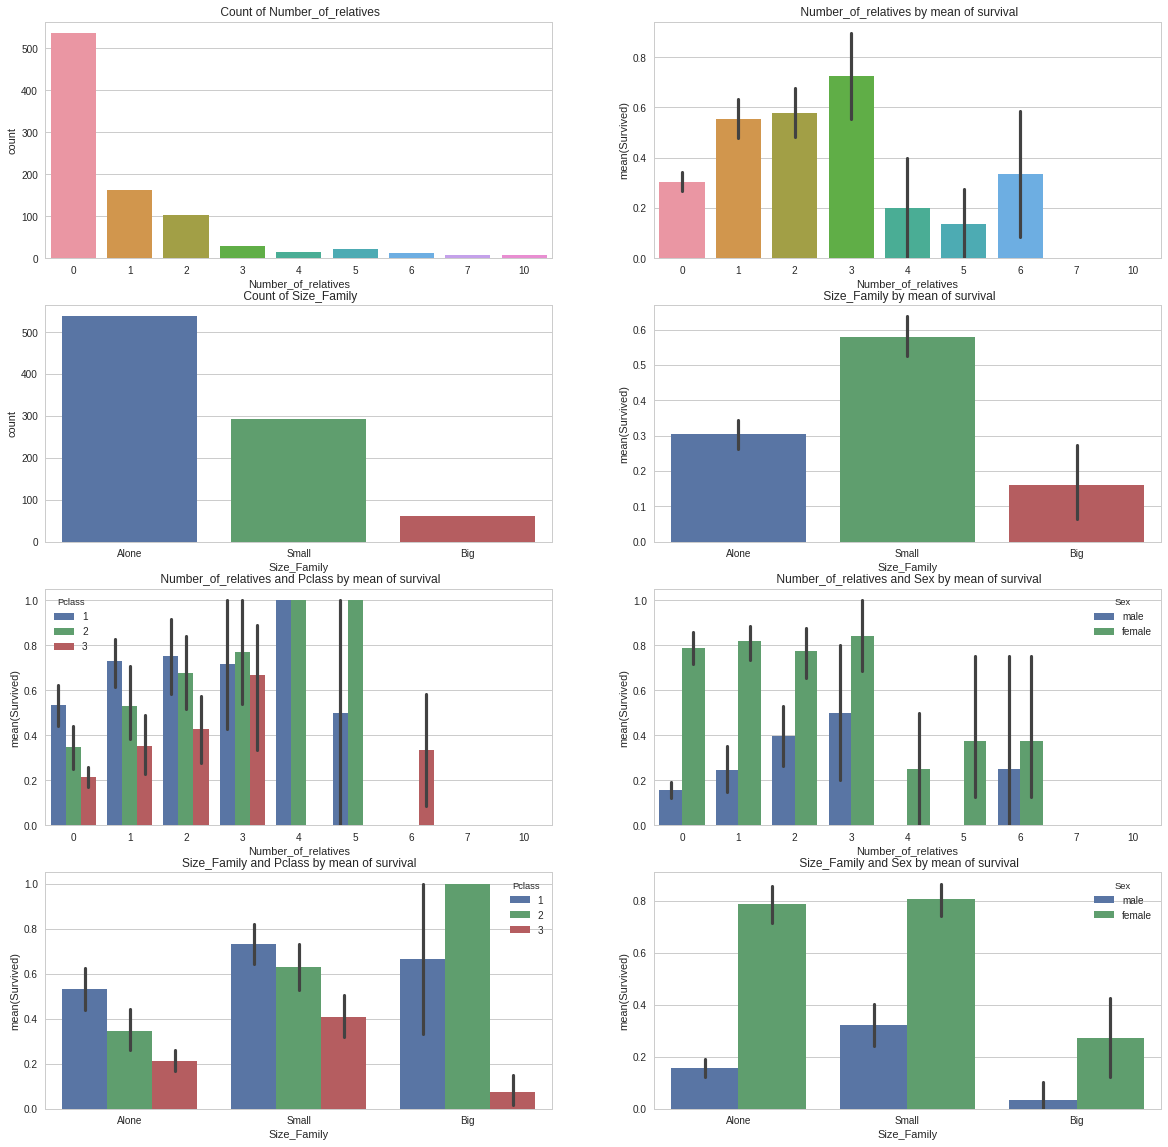

In [27]:
fig, ((axis1,axis2),(axis3,axis4),(axis5,axis6),(axis7,axis8)) = plt.subplots(4,2,figsize=(20,20))

# Plot Number_of_relatives
sns.countplot(x='Number_of_relatives', data=df_train, ax=axis1)
axis1.set_title(" Count of Number_of_relatives")
# Plot Number_of_relatives by mean of survival
fig2 = sns.barplot(x='Number_of_relatives',y='Survived', data=df_train, ax=axis2)
axis2.set_title(" Number_of_relatives by mean of survival")

# Plot Size_Family
sns.countplot(x='Size_Family', data=df_train, order=['Alone', 'Small', 'Big'], ax=axis3)
axis3.set_title(" Count of Size_Family")
# Plot Size_Family by mean of survival
sns.barplot(x='Size_Family',y='Survived', data=df_train, order=['Alone', 'Small', 'Big'], ax=axis4)
axis4.set_title(" Size_Family by mean of survival")

# Plot Number_of_relatives and Pclass 
sns.barplot(x='Number_of_relatives',y='Survived',hue='Pclass', data=df_train, ax=axis5)
axis5.set_title(" Number_of_relatives and Pclass by mean of survival")
# Plot Number_of_relatives and Pclass by mean of survival
sns.barplot(x='Number_of_relatives',y='Survived',hue='Sex', data=df_train, ax=axis6)
axis6.set_title(" Number_of_relatives and Sex by mean of survival")

# Plot Size_Family and Pclass
sns.barplot(x='Size_Family',y='Survived',hue='Pclass', data=df_train, order=['Alone', 'Small', 'Big'], ax=axis7)
axis7.set_title("Size_Family and Pclass by mean of survival")
# Plot Size_Family  and Pclass by mean of survival
sns.barplot(x='Size_Family',y='Survived',hue='Sex', data=df_train, order=['Alone', 'Small', 'Big'], ax=axis8)
axis8.set_title(" Size_Family and Sex by mean of survival")


Observations:
* Number_of_relatives mostly 0, with some 1 and 2
* Size_Family is mostly composed of Alone and Small.
* Size_Family by mean of survival is low for Alone and Big and higher for Small group
* Male get an increase of the rate of survival with Number_of_relatives from 0 to 3

### 5-C Deck

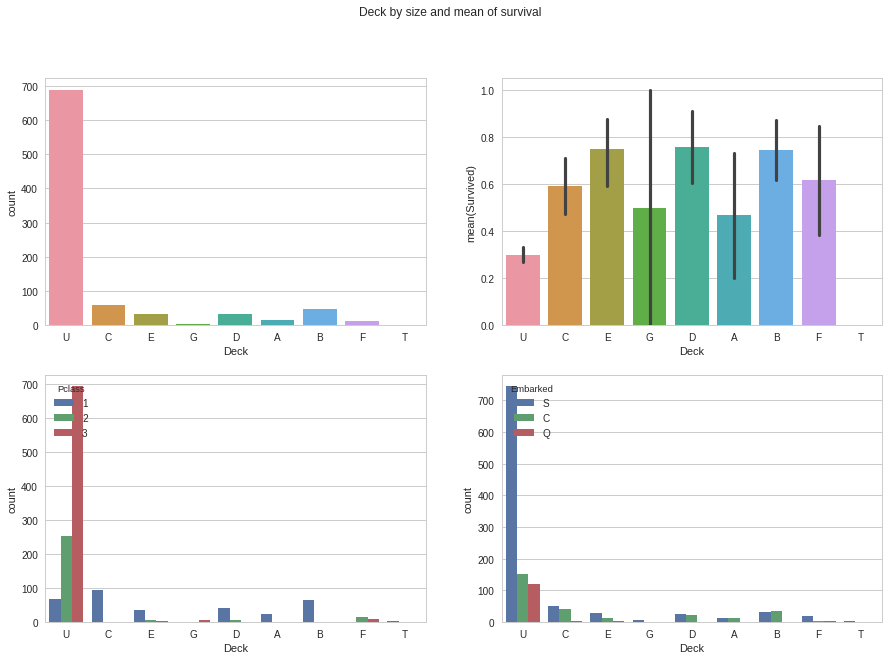

In [28]:
# Show Deck by size and mean of survival
fig6, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,10))
sns.countplot(x='Deck', data=df_train, ax=axis1)
sns.barplot(x='Deck', y='Survived', data=df_train, ax=axis2)
sns.countplot(x='Deck', hue='Pclass', data=combined, ax=axis3)
sns.countplot(x='Deck', hue='Embarked',data=combined, ax=axis4)
fig6.suptitle("Deck by size and mean of survival")

Observations:
* Mostly Unknown and no significant difference for the mean of survival
* No clear correlation with Pclass or Embarked, would be difficult to do some imputation as we only have a small amount available

### 5-D Child

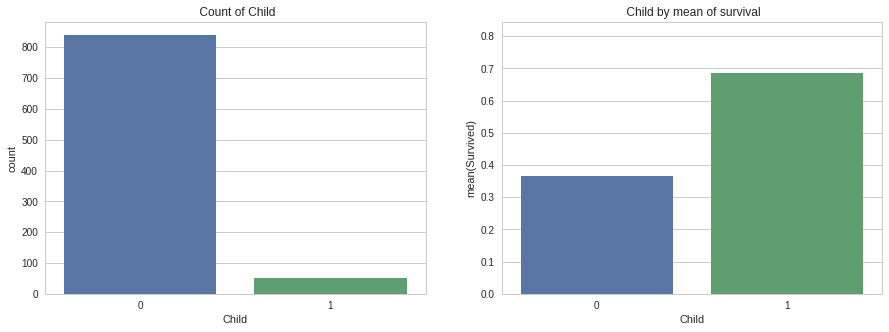

In [29]:
fig6, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
# Plot Child
sns.countplot(df_train['Child'],ax=axis1)
axis1.set_title(" Count of Child")
# Plot Child by mean of survival
sns.barplot(x='Child', y='Survived', data=df_train,errwidth=0,ax=axis2)
axis2.set_title(" Child by mean of survival")

### 5-E All features between Training and Testing set

Test the stratification of features between Training and Testing set, so that we have a better idea of which feature might be usefull. Moreover it can lead to the discover that some feature engineering will certainly not work well.

In [30]:
# Display columns
display(combined.columns)

# Display shape
print('Shape of df_train : ',df_train.shape)
print('Shape of df_test : ',df_test.shape)
print('Shape of combined : ',combined.shape)

# Ratio between the size of the training and testing set
Ratio = df_train.shape[0]/df_test.shape[0]
print('Ratio between training and testing set:',Ratio)

Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch',
       'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Data_set', 'Name_Length', 'Name_Size', 'Title', 'Title_aggr',
       'Number_of_relatives', 'Size_Family', 'Deck', 'Child'],
      dtype='object')

Shape of df_train :  (891, 22)
Shape of df_test :  (418, 22)
Shape of combined :  (1309, 22)
Ratio between training and testing set: 2.1315789473684212


By a countplot we can check if the ratio of 2,1 is followed for the qualitative features

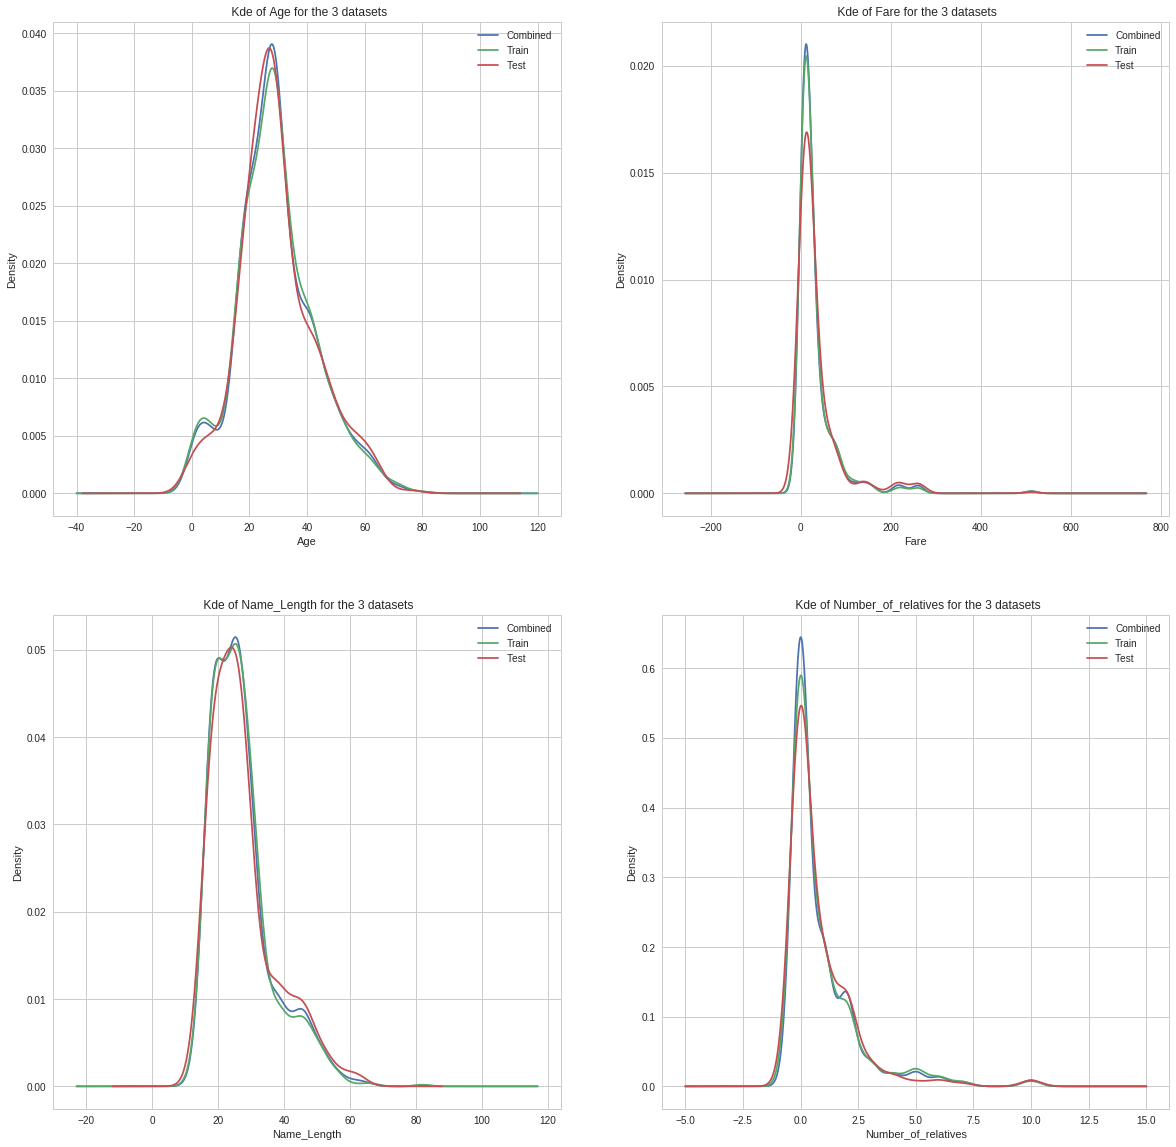

In [31]:
# Kde of Age, Fare, Name_Length and Number_of_relatives
fig, ((axis1,axis2),(axis3,axis4))= plt.subplots(2,2,figsize=(20,20))

# Age distribution within 3 datasets
combined.Age.plot(kind='kde',ax=axis1)    
df_train.Age.plot(kind='kde',ax=axis1)  
df_test.Age.plot(kind='kde',ax=axis1)  
axis1.set_xlabel("Age")    
axis1.set_title(" Kde of Age for the 3 datasets")
axis1.legend(('Combined', 'Train','Test'))

# Fare distribution within 3 datasets
combined.Fare.plot(kind='kde',ax=axis2)    
df_train.Fare.plot(kind='kde',ax=axis2)  
df_test.Fare.plot(kind='kde',ax=axis2)  
axis2.set_xlabel("Fare")    
axis2.set_title(" Kde of Fare for the 3 datasets")
axis2.legend(('Combined', 'Train','Test'))

# Name_Length distribution within 3 datasets
combined.Name_Length.plot(kind='kde',ax=axis3)    
df_train.Name_Length.plot(kind='kde',ax=axis3)  
df_test.Name_Length.plot(kind='kde',ax=axis3)  
axis3.set_xlabel("Name_Length")    
axis3.set_title(" Kde of Name_Length for the 3 datasets")
axis3.legend(('Combined', 'Train','Test'))

# Number_of_relatives distribution within 3 datasets
combined.Number_of_relatives.plot(kind='kde',ax=axis4)    
df_train.Number_of_relatives.plot(kind='kde',ax=axis4)  
df_test.Number_of_relatives.plot(kind='kde',ax=axis4)  
axis4.set_xlabel("Number_of_relatives")    
axis4.set_title(" Kde of Number_of_relatives for the 3 datasets")
axis4.legend(('Combined', 'Train','Test'))

Observations:
* Age from the Test set have a lower bump for child in the kernel density
* Name_Length from Testing have more high values around 40

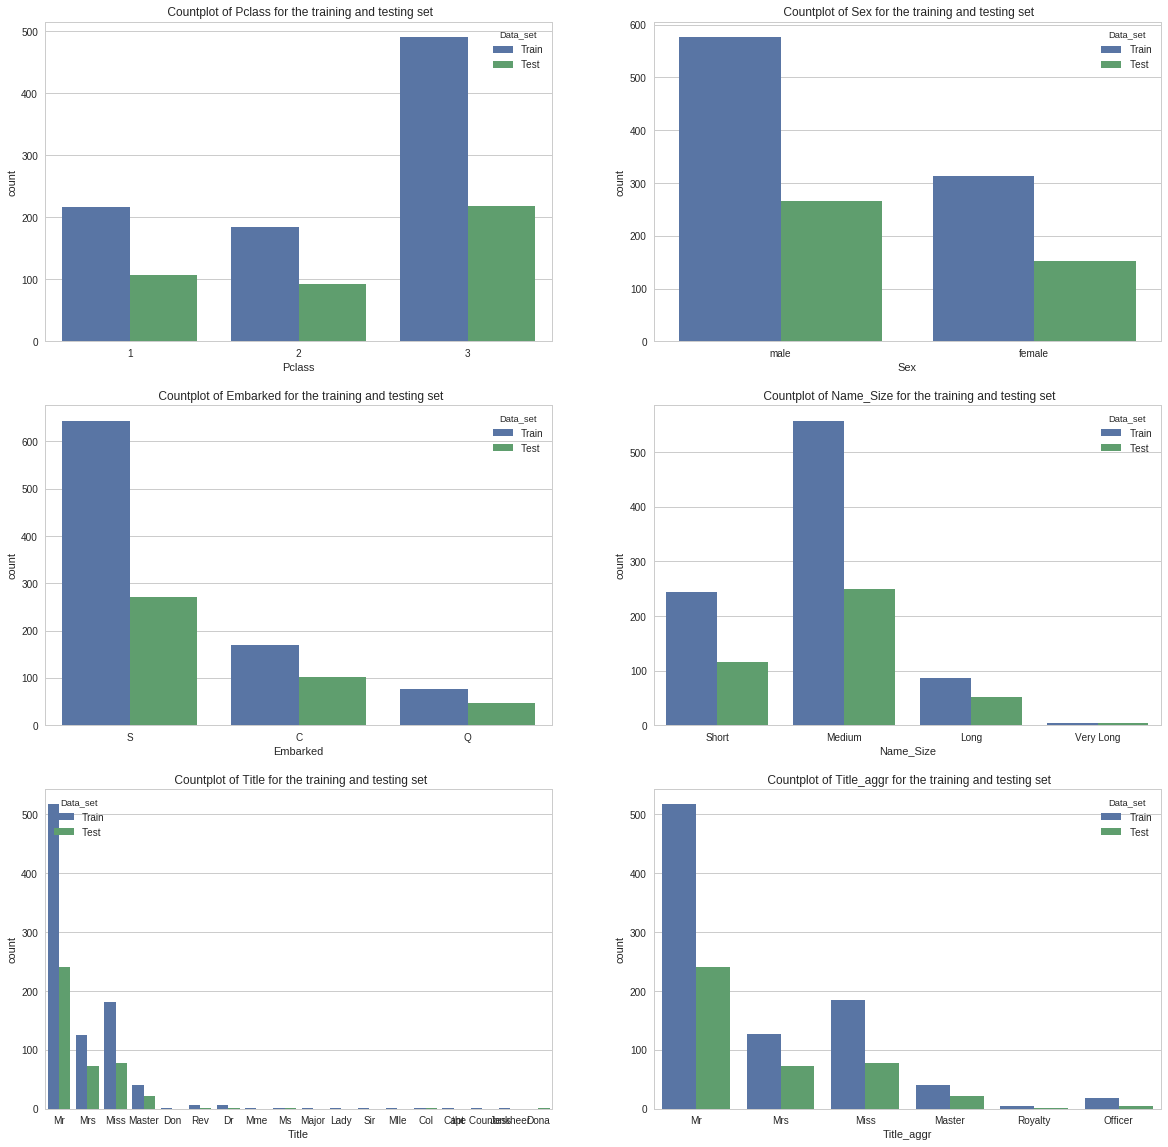

In [32]:
# Count of Pclass, Sex, Embarked, Name_Size, Title and Title_aggr
fig, ((axis1,axis2),(axis3,axis4),(axis5,axis6))= plt.subplots(3,2,figsize=(20,20))

# Pclass
sns.countplot(x='Pclass',hue='Data_set', data=combined, ax=axis1)
axis1.set_xlabel("Pclass")    
axis1.set_title(" Countplot of Pclass for the training and testing set")

# Sex
sns.countplot(x='Sex',hue='Data_set', data=combined, ax=axis2)
axis2.set_xlabel("Sex")    
axis2.set_title(" Countplot of Sex for the training and testing set")

# Embarked
sns.countplot(x='Embarked',hue='Data_set', data=combined, ax=axis3)
axis3.set_xlabel("Embarked")    
axis3.set_title(" Countplot of Embarked for the training and testing set")

# Name_Size
sns.countplot(x='Name_Size',hue='Data_set', data=combined, ax=axis4)
axis4.set_xlabel("Name_Size")    
axis4.set_title(" Countplot of Name_Size for the training and testing set")

# Title
sns.countplot(x='Title',hue='Data_set', data=combined, ax=axis5)
axis5.set_xlabel("Title")    
axis5.set_title(" Countplot of Title for the training and testing set")

# Title_aggr
sns.countplot(x='Title_aggr',hue='Data_set', data=combined, ax=axis6)
axis6.set_xlabel("Title_aggr")    
axis6.set_title(" Countplot of Title_aggr for the training and testing set")

Observations:
* Qualitative features seem well stratified between Train and Test

## 6 - Features Encoding

[[back to top](#Table-of-contents)]

**Note about: Feature encoding**

Typically we distinguish between qualitative and quantitative variables.

Quantitative (also known as numerical) variable is a numerical measurement expressed in terms of numbers and can be classified as:
* Discrete: have a finite number of possible values
* Continuous: have infinite possibilities

Qualitative (also known as categorical) is a variable where the value doesn't represent a quantity but a group which is often referred as level. There is two type of categorical variable:
* Ordinal: have an order
* Nominal: have no order

-----------------------

A lot of implementations of machine learning algorithms require numerical data as input (as in scikit-learn for example), and we have to prepare our data accordingly. So when implementation doesn't treat the problem of categorical features, there is different approaches to represent your features.

Nominal:

The representation that is generally used for nominal is dummy variable also known as one hot encoder.
One dummy variable representing one level from the nominal variable. The information is binary either 1 or 0 to represent the presence or absence of a level. Depending of your application you may need to drop one of the level from the categorical to escape multicolinearity.

Another representation, that is for example often used for the representation of word in natural language processing (NLP), is 1-of-V coding where you represent one level of a nominal feature by a vector where the size is equal to the number of levels of this feature. Each level is represented by a row in the vector with 1 representing the presence and 0 the absence.

Ordinal:

The two representations that are generally used for ordinal are either dummy variable or to transform each categories into a number, where the order and the differences between values matter. For example {low, medium, big} could be encoded as {1, 2, 3}, in this case it assumes that the difference from low to medium and medium to big is 1. It's forcing the model to have an order for this feature. In a lot of case starting with dummy variable enable to see if the model find the order by itself and you may for example use the odds ratios from logistic regression to decide if the distances between levels should be equal or not.

In [33]:
print('Shape of combined : ',combined.shape)
print('Columns of combined :')
display(combined.columns)
#print('Number of Null values by features :')
#display(combined.isnull().sum())
display(combined[["Embarked","Sex","Title_aggr","Size_Family","Name_Size","Pclass"]].head())

Shape of combined :  (1309, 22)
Columns of combined :


Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch',
       'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'Data_set', 'Name_Length', 'Name_Size', 'Title', 'Title_aggr',
       'Number_of_relatives', 'Size_Family', 'Deck', 'Child'],
      dtype='object')

,Embarked,Sex,Title_aggr,Size_Family,Name_Size,Pclass
0,S,male,Mr,Small,Medium,3
1,C,female,Mrs,Small,Long,1
2,S,female,Miss,Alone,Medium,3
3,S,female,Mrs,Small,Long,1
4,S,male,Mr,Alone,Medium,3


### 6-A Binary encoding

In [34]:
# Male is set to 1 and female to 0
combined['Sex'] = combined['Sex'].map(lambda s : 1 if s=='male' else 0)

### 6-B Categorical feature encoding

#### Label Encoding

In [35]:
# Dataframe with numerical categorical feature
combined_num_cat = pd.DataFrame()

# LabelEncoder
labelEnc = LabelEncoder()

# Columns to apply
cat_str_vars = ["Embarked","Title_aggr","Size_Family","Name_Size"]

# Apply to string categorical features
for col in cat_str_vars:
    labelEnc.fit(np.unique(list(combined[col].values)))
    combined_num_cat[col]=labelEnc.transform(combined[col].astype('str'))

    
# Add Sex,Pclass and Child
combined_num_cat['Male'] = combined['Sex']
combined_num_cat['Pclass'] = combined['Pclass']
combined_num_cat['Child'] = combined['Child']

# Display
display(combined_num_cat.head())

,Embarked,Title_aggr,Size_Family,Name_Size,Male,Pclass,Child
0,2,2,2,1,1,3,0
1,0,3,2,0,0,1,0
2,2,1,0,1,0,3,0
3,2,3,2,0,0,1,0
4,2,2,0,1,1,3,0


#### One Hot Encoding

**Note about: One Hot encoder**

When a categorical feature contains two or more levels, a way of representation is to create a One Hot encoder also named dummy variables or indicator variables. It takes the value 0 or 1 to indicate the absence or presence of some level of the categorical feature. A categorical feature with k level will then create k dummy variables. 

The general guideline is as followed: If a variable has k levels, you can create only k-1 indicators. You have to choose one of the k categories as a "baseline" and leave out its indicator. But it depends of the model and the implementation used.

Some of the reasons for this guideline are:

* When giving K indicators it's adding redundancy to the representation of the data. Statistical redundancy has the property that it can be removed from the data without destroying any information.


* Dropping one of the dummy variables may enable to avoid the state of Multicollinearity (e.g. dummy variable trap for regression). Which is a state of perfect correlations among the independent variables, meaning that one can be predicted from the others. It is therefore, a type of disturbance in the data that may affect the results or the performances of the models used. An other way to escape Multicolinearity is to use [regularization][1]
[1]: https://en.wikipedia.org/wiki/Regularization_(mathematics)

Tree-based methods can work directly without One Hot encoder in R or SAS for example but the implementation from sklearn asks for numerical values. Using label encoder (numerical encoder) would induce an order on the categories, so with sklearn implementation I choose to go with One Hot encoder, even if for example Random Forest tend to be robust with label encoding.

When using filter methods for feature selection, you can for example drop the dummy feature that has the lowest/highest relevance to the target. I usually tend to go with the lowest. In theory you have the same information no matter which one you choose to drop, but depending on how the selected model operate it can change slightly the performances.



In [36]:
def one_hot(df_in, cols):
    df_out = pd.DataFrame()
    for each in cols:
        dummies = pd.get_dummies(df_in[each], prefix=each, drop_first=False)
        df_out = pd.concat([df_out, dummies], axis=1)
    return df_out

In [37]:
# Columns to apply
cat_vars=['Embarked',"Title_aggr","Size_Family","Name_Size","Pclass"]

# Get One Hot encoder
combined_One_Hot_Cat = one_hot(combined,cat_vars)

# Add Sex and Child
combined_One_Hot_Cat['Male'] = combined['Sex']
combined_One_Hot_Cat['Child'] = combined['Child']

# Display
display(combined_One_Hot_Cat.head())

,Embarked_C,Embarked_Q,Embarked_S,Title_aggr_Master,Title_aggr_Miss,Title_aggr_Mr,Title_aggr_Mrs,Title_aggr_Officer,Title_aggr_Royalty,Size_Family_Alone,...,Size_Family_Small,Name_Size_Short,Name_Size_Medium,Name_Size_Long,Name_Size_Very Long,Pclass_1,Pclass_2,Pclass_3,Male,Child
0,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,1,0
1,1,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0


### 6-C Feature Scaling

[[back to top](#Table-of-contents)]

**Note about:  Feature Scaling**

Feature scaling is not only important if we are comparing measurements that have different units, but it is also a general requirement for many machine learning algorithms. Feature scaling is a method used to standardize/normalize the range of independent variables. This is generally performed during the data preprocessing step. 

-----------------------------------------------------------------------------------------------

Motivations
  
 * If the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without feature scaling.
 
 * Gradient descent converges much faster with feature scaling than without as it lead to increase the convergence speed and often the performances.
 
 -----------------------------------------------------------------------------------------------
 
Two of the main methods for feature scaling are:
 
 * **Standardization** also known as Z-score normalization
 
    The result of standardization is that the features will be rescaled so that they'll have the properties of a standard normal distribution with $\mu = 0$ and $\sigma = 1$, where $\mu$ is the mean and $\sigma$ is the standard deviation. Let $x$ be the feature that is going to be standardized, as follow:
    
    \begin{equation} z = \frac{x - \mu}{\sigma}\end{equation} 
    
    As a result, all variables in the data set have equal means 0 and standard deviations 1 but different ranges.
    
    This method is widely used in many machine learning algorithms (e.g., support vector machines, logistic regression, and neural networks)
      
    
* **Normalization** also known as Feature scaling

    In Normalization, the data are scaled to a fixed range, usually [0,1] or [-1,1]. The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers. Let $x$ be the feature that is going to be normalized and $X_{min}=min(x)$  (resp. $X_{max}=max(x)$) 
    
  The 0-1 scaling or Min-Max scaling is as followed: \begin{equation} X_{norm} = \frac{x - X_{min}}{X_{max}-X_{min}} \end{equation}    
    This method allows variables to have differing means and standard deviations but equal ranges. In this case, there is at least one observed value at the 0 and 1 endpoints.
   Typical application of 0-1 scaling is for image processing and some neural network that require data on 0-1 scale.
     
   
   
-----------------------------------------------------------------------------------------------

Some examples of models:

* Scale-invariant 
    * Tree-based methods.   

* Scale-variant 
    * K-nearest neighbors, k-means with an euclidean distance
    * Logistic regression, SVMs, perceptrons, neural networks etc., while using gradient descent-based optimization
    * Linear discriminant analysis, principal component analysis etc. since the model want to find direction for maximizing the variance, so scale impact on measurement of a feature.


In [38]:
# Columns and dataframe for features scalling
std_columns = ['Fare','Age','Name_Length','Number_of_relatives']
combined_num_std = pd.DataFrame(combined[std_columns])

# StandardScaller process
std_scale = StandardScaler()
combined_num_std[std_columns] = std_scale.fit_transform(combined[std_columns].astype(float))

# Display before and after
display(combined[std_columns].head())
display(combined_num_std[std_columns].head())

,Fare,Age,Name_Length,Number_of_relatives
0,7.2500,22,23,1
1,71.2833,38,51,1
2,7.9250,26,22,0
3,53.1000,35,44,1
4,8.0500,35,24,0


,Fare,Age,Name_Length,Number_of_relatives
0,-0.503176,-0.553913,-0.434672,0.073352
1,0.734809,0.638517,2.511806,0.073352
2,-0.490126,-0.255805,-0.539904,-0.558346
3,0.383263,0.414936,1.775186,0.073352
4,-0.487709,0.414936,-0.329441,-0.558346


/home/jules/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


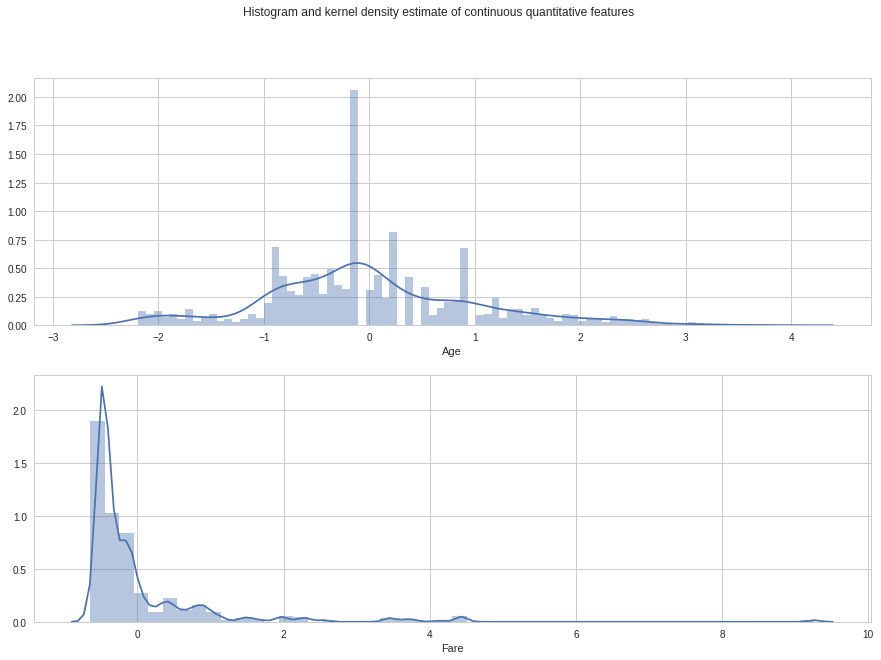

In [39]:
# Continuous Quantitative Data : [Age, Fare]
fig3, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))
sns.distplot(combined_num_std['Age'].dropna(), bins=80, ax=axis1)
sns.distplot(combined_num_std['Fare'], ax=axis2)
fig3.suptitle("Histogram and kernel density estimate of continuous quantitative features")

### 6-D Data Preparation

Available :
* combined_num_std
* combined_One_Hot_Cat
* combined_num_cat

Creation of 2 data sets:
* label encoder + scaled quantitative features
* one hot encoder + scaled quantitative features 

In [40]:
# Concat into One Hot or Label encoding
combined_OH_Std = pd.concat([combined_num_std,combined_One_Hot_Cat],axis=1)
combined_Num_Std = pd.concat([combined_num_std,combined_num_cat],axis=1)

# Display shape
print('Shape of combined_OH_Std : ',combined_OH_Std.shape)
print('Shape of combined_Num_Std : ',combined_Num_Std.shape)

Shape of combined_OH_Std :  (1309, 25)
Shape of combined_Num_Std :  (1309, 11)


In [41]:
# Split into Train and Eval for submit prediction on kaggle
Train_OH_Std, Eval_OH_Std= split_train_test(combined_OH_Std)
Train_Num_Std, Eval_Num_Std = split_train_test(combined_Num_Std)

# Display shape
print('Shape of Train_OH_Std : ',Train_OH_Std.shape)
print('Shape of Eval_OH_Std : ',Eval_OH_Std.shape)

Shape of Train_OH_Std :  (891, 25)
Shape of Eval_OH_Std :  (418, 25)


In [42]:
# Select Data to use
data = Train_OH_Std
test_data = Eval_OH_Std
target = targets
columns_name = list(Train_OH_Std)

# Train & Validation set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state = 123,stratify=target)

# Dataframe of prediction
Prediction = pd.DataFrame()

## 7 - Features Selection


[[back to top](#Table-of-contents)]

The feature selection part is a demonstration of how one may do feature selection with filter, wrapper and embedded methods using mostly sk-learn. It show the first attempt to do feature selection and not the final choice that require trials of subset of features and the tuning of models for each selected subset.

Therefore, the feature selection made on this notebook does not give the best results but show how it can be made. Using regularization may enable to let all the level on some important qualitative features and lead to perform better than systematically deleting one level. 

This part is about analyzing which features is important for the classification task and which to drop.

Study the relation between:

* Target and quantitative features with:
    * Point Biserial Pearson Correlation
    * Anova
    * Linear Discriminant Analysis
        
        
* Target and one hot categorical encoding with:
    * Pearson Phi
    * Chi 2 Independence and Cramer V
    * Hamming and Dice distance      
    
        
* Target and all features with:
    * Logistic Regression
    * Random Forest
    * Recursive Feature Elimination with Logistic Regression


** _Note about : Dimensionality Reduction_ **

Dimensionality Reduction can be divided into Feature Selection and Feature Extraction. However, dimensionality reduction is also used a lot in reference to Feature Extraction.

Both methods seek to reduce the number of variables in the dataset, but a feature extraction method do so by creating new combinations of variables, where a feature selection method include and exclude variables present in the data without changing them.

---------

** Feature Selection **

Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant features from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.

Three benefits of performing feature selection before modeling data are:

* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
* Improves Accuracy: Less misleading data means modeling accuracy improves.
* Reduces Training Time: Less data means that algorithms train faster.


There are three general classes of feature selection algorithms: filter methods, wrapper methods and embedded methods.

**Filter** Methods: 

Filter type methods select variables regardless of the model, but by applying a statistical measure to assign a score to each feature. The methods are often univariate or bivariate. The features are ranked by the score and either selected to be kept or removed from the dataset.
Some examples are:
* information gain
* chi-square test
* fisher score
* pearson product-moment correlation coefficient
* variance threshold

These methods are particularly effective in computation time and relatively robust to overfitting
The main disadvantage is that filter methods tend to select redundant variables because they do not consider the relationships between variables. Therefore, they are mainly used as a pre-process methods, before Wrapper or Embedded methods.
       
**Wrapper** Methods:

Wrapper methods consider the selection of a set of features as a search problem, using a fixed predictive model to score feature subsets where different combinations are evaluated and compared to other combinations

Wrapper methods use a predictive model to measure the quality of subsets of features without incorporating knowledge about the specific structure of the classification or regression function, and can therefore be combined with any learning machine.

Wrapper methods evaluate subsets of variables which allows, unlike filter approaches, to detect the possible interactions between variables. Some example are:
* Recursive feature elimination
* Sequential feature selection algorithms
* Genetic algorithms

The two main disadvantages of Wrapper methods are:
* The increasing overfitting risk when the number of observations is insufficient.
* The significant computation time when the number of variables is large.

**Embedded** Methods:

There are models that learn which features best contribute to the performance of the model, while the model is being created. These models compute feature importance that can be used to discard unimportant features.
Embedded methods takes advantage of the variable selection process of a model and performs feature selection and classification simultaneously.

These approaches tend to be between filters and wrappers in terms of computational complexity and less prone to overfitting. Embedded methods, are quite similar to wrapper methods since they are also used to optimize the objective function. The difference to wrapper methods is that an intrinsic model building metric is used during learning. Some examples:
* L1 (LASSO) regularization
* Decision tree-based model feature importance
* Recursive feature elimination with SVM (can be seen as wrapper)

The boundaries are not really well defined especially between Wrapper and Embedded.

------------

** Feature Extraction **

Feature extraction serves two purposes, analyzing and reducing your features. 
Feature extraction transforms the data from a high-dimensional space to a space of fewer dimensions, having two purposes which are analyzing or reducing. 

When the number of features is high, or if you suspect that some of the features might not be meaningful or not well represented, you can use feature extraction methods to reduce the number of features or to get a better understanding thanks to the axis obtain than enable you to visualize high dimensional data in a set of 2D plot.  As feature extraction is about reducing the numbers of features and saving a lot of the information, in PCA for example when you choose the number of principal components to use, you also choose the percentage of variance explained by the representation.

If you choose to take a number of principal components as input of your models or others analysis, you are losing a certain amount of information and you may also loose the easiness of explaining your models, but you gain stronger features that can be used as input of various machine learning. Feature extraction is often used before a clustering or classification tasks.

As an alternative, you can study your features with the results of the feature extraction methods and others analysis to choose if some features need to be dropped.

Some of the main methods are: 
* Principal Component Analysis (PCA), unsupervised, which takes quantitative features and returns axes of maximal variance.
* Multiple Correspondence Analysis (MCA), unsupervised, which takes qualitative features and appears to be the counterpart of principal component analysis for categorical data
* Linear Discriminant Analysis (LDA), supervised, returns axes that maximizes class separability.
* Kernel PCA : uses kernel trick to transform non-linear data to a feature space were samples may be linearly separable
* Advanced methods like t-SNE

As the results of PCA and MCA are quantitative features, using MCA may enable to switch representation from categorical to quantitative features.

It shall be noted though that regularization in classification models such as Logistic Regression, Support Vector Machines, or Neural Networks is to be preferred over using feature extraction to avoid overfitting. However, feature extraction is still a useful data compression technique to increase computational efficiency and data storage problems.

### 7-A Filter Methods

#### Quantitative Features

In [43]:
# Features to apply
Quantitative = ['Fare','Age','Name_Length','Number_of_relatives']

# Concatenate data and target
QF_Target = pd.concat([data[Quantitative],target],axis=1)

# Create Survied and Died set
Survived = QF_Target[QF_Target['Survived'] == 1]
Died = QF_Target[QF_Target['Survived'] == 0]

# Create results dataframes
PointBiser = pd.DataFrame()
TTest = pd.DataFrame()
Anova = pd.DataFrame()
Lda = pd.DataFrame() 

for var in enumerate(Quantitative) : 
    
    # Point Biserial correlation
    pb = stats.pointbiserialr(QF_Target['Survived'], QF_Target[var[1]])
    PointBiser.loc[var[0],'Feature'] = var[1]
    PointBiser.loc[var[0],'Point Biserial Pearson Corr'] = pb.correlation
    PointBiser.loc[var[0],'Pval'] = pb.pvalue
    PointBiser.sort_values('Pval',ascending=True,inplace=True)
    
    # One way Anova
    anova_one_way = stats.f_oneway(Survived[var[1]], Died[var[1]])
    Anova.loc[var[0],'Feature'] = var[1]
    Anova.loc[var[0],'Anova F value'] = anova_one_way[0]
    Anova.loc[var[0],'Pval'] = anova_one_way[1]
    Anova.sort_values('Pval',ascending=True,inplace=True)  
    
# LDA
lda = LinearDiscriminantAnalysis(n_components = 2, solver='svd')
lda.fit(X_train[Quantitative], y_train)
Lda['Feature'] = Quantitative
Lda['LDA Coef'] = lda.coef_.transpose()
Lda.sort_values('LDA Coef',ascending=False,inplace=True)

y_train_pred_lda = lda.predict(X_train[Quantitative])
y_test_pred_lda = lda.predict(X_test[Quantitative])

lda_acc = accuracy_score(y_test, y_test_pred_lda)
lda_cr= classification_report(y_test, y_test_pred_lda)
lda_cm = confusion_matrix(y_test, y_test_pred_lda)

lda_acc_train = accuracy_score(y_train, y_train_pred_lda)
lda_cr_train = classification_report(y_train, y_train_pred_lda)
lda_cm_train = confusion_matrix(y_train, y_train_pred_lda)

# Display results
display(PointBiser)
display(Anova)
display(Lda)

# LDA Results
print("LDA Results\n")
print("-----------------------------------------------------------------------------")
print("Training set")
print( "LDA Accuracy :", lda_acc_train)
print(lda_cr_train)
print("Confusion Matrix :\n",lda_cm_train)
print('Balance of classes',lda.priors_)
print("-----------------------------------------------------------------------------")
print("Testing set")
print( "LDA Accuracy :", lda_acc)
print(lda_cr)
print("Confusion Matrix :\n",lda_cm)
print("-----------------------------------------------------------------------------")

,Feature,Point Biserial Pearson Corr,Pval
2,Name_Length,0.332350,2.026795e-24
0,Fare,0.257307,6.120189e-15
1,Age,-0.072540,3.037917e-02
3,Number_of_relatives,0.016639,6.198911e-01


,Feature,Anova F value,Pval
2,Name_Length,110.388690,2.026795e-24
0,Fare,63.030764,6.120189e-15
1,Age,4.702738,3.037917e-02
3,Number_of_relatives,0.246193,6.198911e-01


,Feature,LDA Coef
2,Name_Length,0.923810
0,Fare,0.622296
1,Age,-0.405051
3,Number_of_relatives,-0.408985


LDA Results

-----------------------------------------------------------------------------
Training set
LDA Accuracy : 0.724719101124
             precision    recall  f1-score   support

          0       0.72      0.90      0.80       439
          1       0.74      0.44      0.55       273

avg / total       0.73      0.72      0.70       712

Confusion Matrix :
 [[397  42]
 [154 119]]
Balance of classes [ 0.61657303  0.38342697]
-----------------------------------------------------------------------------
Testing set
LDA Accuracy : 0.737430167598
             precision    recall  f1-score   support

          0       0.72      0.93      0.81       110
          1       0.79      0.43      0.56        69

avg / total       0.75      0.74      0.72       179

Confusion Matrix :
 [[102   8]
 [ 39  30]]
-----------------------------------------------------------------------------


Observations:

**Point Biserial Corr** - Pearson Corr apply to nominal and continuous features:
* Very Small correlation for Age and Number_of_relatives with high p-values
* Positive correlation for Fare and Name_Length with very small p-value
    
**Anova** - Test mean equality between survived and not survived:
* Can reject mean equality for Fare and Length
* Can say nothing about Age and Number_of_relatives
    
**LDA** - Linear Discriminant Analysis 
* Fare and Length have a positive and high coefficient
* Age and Number_of_relatives have a negative and smaller coefficient

#### Qualitative Features

**Note about: χ2 test, Cramer V and p-value**

The p-value from the χ2 test tells you the probability of getting a χ2 statistic as extreme as or more extreme than yours if the null hypothesis is true, but tells you nothing about how big the effect is.

On the other hand, Cramer's V which is based on χ2 statistic is a measure of effect size. It tells you how big the effect is but tells you nothing about whether or not the effect is 'significant'. 

In [44]:
from scipy.spatial import distance
import scipy.stats as ss

def Cramer_Chi2(crosstab):
    n = crosstab.sum().sum()
    chi2 = ss.chi2_contingency(crosstab)[0]
    pval = ss.chi2_contingency(crosstab)[1]
    CramerV = np.sqrt(chi2 / (n* (min(crosstab.shape) -1)))
    return CramerV, chi2, pval

In [45]:
# Features to apply
Qualitative = list(combined_One_Hot_Cat.columns)

# Concant data and target
QF_OH_Target = pd.concat([data[Qualitative],target],axis=1)

# Result and temp dataframe
confusion_mat = pd.DataFrame()
Corr = pd.DataFrame()

Corr['Pearson Phi'] = QF_OH_Target.corr(method='pearson')["Survived"]

for var in enumerate(Qualitative) : 
    confusion_mat = pd.crosstab(QF_OH_Target['Survived'], QF_OH_Target[var[1]])
    Corr.loc[var[1],'Cramer V'] = Cramer_Chi2(confusion_mat)[0]
    Corr.loc[var[1],'Test Chi 2 - Independance'] = Cramer_Chi2(confusion_mat)[1]
    Corr.loc[var[1],'Chi 2 Pval']= Cramer_Chi2(confusion_mat)[2]
    Corr.loc[var[1],'Hamming Distance'] = distance.hamming(QF_OH_Target['Survived'].astype(int), QF_OH_Target[var[1]].astype(int))
    Corr.loc[var[1],'Dice Coefficient'] = distance.dice(QF_OH_Target['Survived'].astype(int), QF_OH_Target[var[1]].astype(int))
    
Corr.sort_values('Chi 2 Pval',ascending=True,inplace=True)
display(Corr)

,Pearson Phi,Cramer V,Test Chi 2 - Independance,Chi 2 Pval,Hamming Distance,Dice Coefficient
Title_aggr_Mr,-0.549199,0.546861,266.459805,6.706529e-60,0.782267,0.811409
Male,-0.543351,0.540936,260.717020,1.197357e-58,0.786756,0.762786
Title_aggr_Mrs,0.344935,0.341634,103.992178,2.031164e-24,0.299663,0.569296
Title_aggr_Miss,0.332795,0.329945,96.997487,6.941537e-23,0.300786,0.509506
Pclass_3,-0.322308,0.319988,91.231792,1.277905e-21,0.667789,0.714286
Pclass_1,0.285904,0.283211,71.465839,2.821002e-17,0.320988,0.512545
Size_Family_Small,0.279855,0.277396,68.561247,1.229976e-16,0.332211,0.466877
Name_Size_Long,0.273448,0.269540,64.732768,8.577650e-16,0.327722,0.682243
Size_Family_Alone,-0.203367,0.201009,36.000514,1.972654e-09,0.620651,0.629124
Name_Size_Short,-0.193143,0.190552,32.352293,1.286054e-08,0.530864,0.808547


**Pearson Phi**:
* Very small correlation:
    - Pclass_2
    - Title_aggr_Master
    - Name_Size_Very Long
    - Title_aggr_Royalty
    - Embarked_Q
    - Name_Size_Medium
* High Correlation:
    - Positive: 
        - Sex_female
        - Title_aggr_Mrs
        - Title_aggr_Miss
        - Pclass_1
        - Size_Family_Small
        - Name_Size_Long
    - Negative: 
        - Sex_male
        - Pclass_3

**Chi 2 Independence and Cramer V**:
* We can reject independence and the Cramer Corelation if high for:
    - Title_aggr_Mr 
    - Sex_female 
    - Sex_male
    --> The information of this 3 features is mostly the same
* We can reject independence and the Cramer Correlation is medium for:
    - Title_aggr_Mrs 
    - Title_aggr_Miss 
    - Pclass_3
    - Pclass_1
    - Size_Family_Small
    - Name_Size_Long
    - Size_Family_Alone
    - Name_Size_Short
* We can reject independence but the Cramer Correlation is low:
    - Embarked_C
    - Embarked_S
    - Size_Family_Big
* At 5 % we can't reject independence and the Cramer Correlation if very small:
    - Name_Size_Very Long
    - Title_aggr_Officer
    - Title_aggr_Royalty
    - Name_Size_Medium
    - Embarked_Q 
        
**Hamming distance - Tell us about the numbers of difference**:
* High distance:
    - Sex_male
    - Title_aggr_Mr 
    - Pclass_3
    - Size_Family_Alone
    - Embarked_S
* Medium:
    - Name_Size_Short
    - Name_Size_Medium
    - Size_Family_Big
    - Embarked_Q
    - Pclass_2
    - Title_aggr_Officer
    - Title_aggr_Royalty
    - Name_Size_Very Long 
    - Title_aggr_Master
    - Embarked_C
* Small distance:
    - Size_Family_Small
    - Name_Size_Long
    - Pclass_1
    - Title_aggr_Miss
    - Title_aggr_Mrs
    - Sex_female
   
**Dice - Tell us about how much disjoint (0) or equal (1)**:
* Mostly disjoint:
    - Sex_female
* Medium:
    - Size_Family_Alone
    - Embarked_C
    - Title_aggr_Mrs
    - Embarked_S
    - Name_Size_Medium
    - Pclass_1
    - Title_aggr_Miss
    - Size_Family_Small
* Mostly joint:
    - Title_aggr_Royalty
    - Name_Size_Very Long
    - Title_aggr_Officer
    - Size_Family_Big
    - Title_aggr_Master
    - Embarked_Q
    - Title_aggr_Mr
    - Name_Size_Short
    - Sex_male
    - Pclass_3

#### Correlation matrix

Let plot the correlation matrix to see which features are highly correlated as it is one of the disadvantage of using filter methods

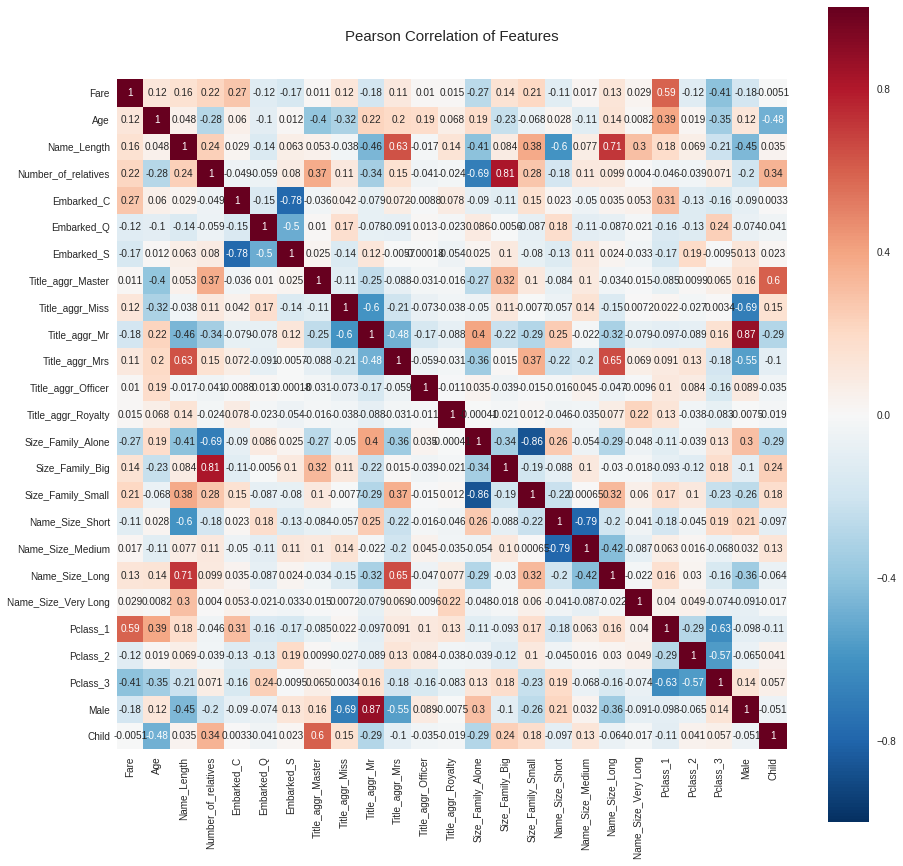

In [46]:
corr = data.corr()
fig, axis1 = plt.subplots(figsize=(15,15))
sns.heatmap(corr, square=True, annot=True, ax=axis1)
plt.title('Pearson Correlation of Features', y=1.05, size=15)

### 7-B Feature importance with embedded methods

#### Feature importance using Logistic Regression

In [47]:
# Logistic Regression
Lr = pd.DataFrame()
lr = LogisticRegression()
lr.fit(X_train, y_train)
Lr['Feature'] = list(X_train.columns)
Lr['LR Coef'] = lr.coef_.transpose()
Lr['Odds Ratios'] = np.exp(lr.coef_.transpose())
Lr.sort_values('LR Coef',ascending=False,inplace=True)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

lr_acc = accuracy_score(y_test, y_test_pred_lr)
lr_cr= classification_report(y_test, y_test_pred_lr)
lr_cm = confusion_matrix(y_test, y_test_pred_lr)

lr_acc_train = accuracy_score(y_train, y_train_pred_lr)
lr_cr_train = classification_report(y_train, y_train_pred_lr)
lr_cm_train = confusion_matrix(y_train, y_train_pred_lr)

display(Lr)

# Logistic Regression Results
print("Logistic Regression Results\n")
print("-----------------------------------------------------------------------------")
print("Training set")
print( "LR Accuracy :", lr_acc_train)
print(lr_cr_train)
print("Confusion Matrix :\n",lr_cm_train)
print("-----------------------------------------------------------------------------")
print("Testing set")
print( "LR Accuracy :", lr_acc)
print(lr_cr)
print("Confusion Matrix :\n",lr_cm)
print("-----------------------------------------------------------------------------")

#print('intercept',lr.intercept_)

,Feature,LR Coef,Odds Ratios
7,Title_aggr_Master,1.222120,3.394376
20,Pclass_1,1.086915,2.965113
24,Child,0.988784,2.687964
10,Title_aggr_Mrs,0.928423,2.530515
15,Size_Family_Small,0.681432,1.976707
13,Size_Family_Alone,0.628705,1.875180
19,Name_Size_Very Long,0.341100,1.406493
5,Embarked_Q,0.335607,1.398790
18,Name_Size_Long,0.299573,1.349282
8,Title_aggr_Miss,0.239890,1.271110


Logistic Regression Results

-----------------------------------------------------------------------------
Training set
LR Accuracy : 0.837078651685
             precision    recall  f1-score   support

          0       0.85      0.89      0.87       439
          1       0.81      0.76      0.78       273

avg / total       0.84      0.84      0.84       712

Confusion Matrix :
 [[389  50]
 [ 66 207]]
-----------------------------------------------------------------------------
Testing set
LR Accuracy : 0.832402234637
             precision    recall  f1-score   support

          0       0.84      0.89      0.87       110
          1       0.81      0.74      0.77        69

avg / total       0.83      0.83      0.83       179

Confusion Matrix :
 [[98 12]
 [18 51]]
-----------------------------------------------------------------------------


Observations:
* The following categorical features don't affect the survival so much (less than 8% differences) as their odds ratio are close to 1:
    * Embarked_C
    * Name_Size_Long
    * Pclass_2
    * Name_Size_Medium
    * Name_Size_Short


* Note that as the quantitative features are standardized so the odds ratio values are much higher that what they would have been with their normal ranges of values.

Was able to perform logistic regression with all the features from each categorical variable because of the default regularization in the logistic regression from sk-learn that help to escape from multicoliearity problems (can try running the cell below to see what happen with the logistic regression from statsmodel that doesn't have regularization by default)

In [48]:
# Not working properly because of multicolinearity problems
#import statsmodels.api as sm
# Add or not an intercept term
#X_train['one'] = 1
#logit = sm.Logit(y_train, X_train)
#result = logit.fit()
#print(result.summary())

#### Feature importance using Random Forest

In [49]:
# Random Forest
Rf = pd.DataFrame()
param_rf = {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 30}
rf = RandomForestClassifier(**param_rf)
rf.fit(X_train, y_train)
Rf['Feature'] = list(X_train.columns)
Rf['Rf Coef'] = rf.feature_importances_
Rf.sort_values('Rf Coef',ascending=False,inplace=True)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

rf_acc = accuracy_score(y_test, y_test_pred_rf)
rf_cr= classification_report(y_test, y_test_pred_rf)
rf_cm = confusion_matrix(y_test, y_test_pred_rf)

rf_acc_train = accuracy_score(y_train, y_train_pred_rf)
rf_cr_train = classification_report(y_train, y_train_pred_rf)
rf_cm_train = confusion_matrix(y_train, y_train_pred_rf)

display(Rf)

# Random Forest Results
print("Random Forest Results\n")
print("-----------------------------------------------------------------------------")
print("Training set")
print( "RF Accuracy :", rf_acc_train)
print(rf_cr_train)
print("Confusion Matrix :\n",rf_cm_train)
print("-----------------------------------------------------------------------------")
print("Testing set")
print( "RF Accuracy :", rf_acc)
print(rf_cr)
print("Confusion Matrix :\n",rf_cm)
print("-----------------------------------------------------------------------------")

,Feature,Rf Coef
9,Title_aggr_Mr,0.197611
23,Male,0.178180
0,Fare,0.102754
10,Title_aggr_Mrs,0.079504
1,Age,0.072115
8,Title_aggr_Miss,0.061589
22,Pclass_3,0.060110
2,Name_Length,0.056804
3,Number_of_relatives,0.044632
20,Pclass_1,0.027383


Random Forest Results

-----------------------------------------------------------------------------
Training set
RF Accuracy : 0.856741573034
             precision    recall  f1-score   support

          0       0.85      0.92      0.89       439
          1       0.86      0.75      0.80       273

avg / total       0.86      0.86      0.85       712

Confusion Matrix :
 [[406  33]
 [ 69 204]]
-----------------------------------------------------------------------------
Testing set
RF Accuracy : 0.837988826816
             precision    recall  f1-score   support

          0       0.85      0.90      0.87       110
          1       0.82      0.74      0.78        69

avg / total       0.84      0.84      0.84       179

Confusion Matrix :
 [[99 11]
 [18 51]]
-----------------------------------------------------------------------------


Observations:
* This features have a really low importance for the tuned Random Forest Classifier:
    * Title_aggr_Master
    * Embarked_Q 
    * Name_Size_Short
    * Embarked_C
    * Title_aggr_Officer
    * Name_Size_Very Long
    * Title_aggr_Royalty

### 7-C First Drop

Using the analysis done just before we can make first selection of features to drop.

I took the choice to drop:

* Number_of_relatives
* Name_Length
* Pclass_2
* Embarked_Q
* Name_Size_Medium
* Name_Size_Very Long
* Title_aggr_Royalty
* Title_aggr_Officer
* Size_Family_Big

In [50]:
# Display shape before
print('Shape before:')
display(data.shape)
display(test_data.shape)

# Dropping the features
var_to_drop =['Number_of_relatives','Name_Length','Pclass_2','Embarked_Q','Name_Size_Medium','Name_Size_Very Long','Title_aggr_Royalty','Title_aggr_Officer','Size_Family_Big']
#var_to_drop2 = ['Number_of_relatives','Name_Length','Title_aggr_Royalty','Title_aggr_Officer','Name_Size_Medium','Embarked_C','Pclass_2','Size_Family_Big']
data.drop(var_to_drop,axis=1,inplace=True)
test_data.drop(var_to_drop,axis=1,inplace=True)  

# Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20,random_state = 123,stratify=target)

# Display shape after
print('Shape after:')
display(data.shape)
display(test_data.shape)

Shape before:


(891, 25)

(418, 25)

Shape after:


/home/jules/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jules/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(891, 16)

(418, 16)

### 7-D Recursive feature elimination

Optimal number of features for accuracy: 6
Optimal number of features for f1: 12
Optimal number of features for precision: 6
Optimal number of features for recall: 12


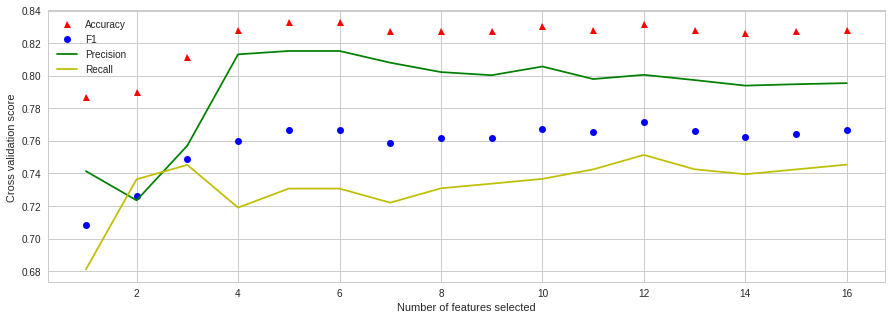

,Feature,RFECV Accuracy rank,RFECV f1 rank,RFECV Pressision rank,RFECV Recall rank
4,Title_aggr_Master,1,1,1,1
8,Size_Family_Alone,1,1,1,1
9,Size_Family_Small,1,1,1,1
12,Pclass_1,1,1,1,1
14,Male,1,1,1,1
15,Child,1,1,1,1
13,Pclass_3,2,1,2,1
6,Title_aggr_Mr,3,1,3,1
11,Name_Size_Long,4,1,4,1
3,Embarked_S,5,1,5,1


In [51]:
from sklearn.feature_selection import RFECV

# Recursive feature elimination using Logistic Regression and different metrics
lr = LogisticRegression()
#svc = SVC(kernel='linear')

rfecv_acc = RFECV(estimator=lr, step=1, cv=10, scoring = 'accuracy')
rfecv_f1 = RFECV(estimator=lr, step=1, cv=10, scoring = 'f1')
rfecv_prec = RFECV(estimator=lr, step=1, cv=10, scoring = 'precision')
rfecv_recall = RFECV(estimator=lr, step=1, cv=10, scoring = 'recall')

rfecv_acc.fit(data, target)
rfecv_f1.fit(data, target)
rfecv_prec.fit(data, target)
rfecv_recall.fit(data, target)

print("Optimal number of features for accuracy: %d" % rfecv_acc.n_features_)
print("Optimal number of features for f1: %d" % rfecv_f1.n_features_)
print("Optimal number of features for precision: %d" % rfecv_prec.n_features_)
print("Optimal number of features for recall: %d" % rfecv_recall.n_features_)

fig, axis1 = plt.subplots(figsize=(15,5))
axis1.set_xlabel("Number of features selected")
axis1.set_ylabel("Cross validation score ")
axis1.plot(range(1, len(rfecv_acc.grid_scores_) + 1), rfecv_acc.grid_scores_, 'r^', label = 'Accuracy')
axis1.plot(range(1, len(rfecv_f1.grid_scores_) + 1), rfecv_f1.grid_scores_, 'bo', label = 'F1')
axis1.plot(range(1, len(rfecv_prec.grid_scores_) + 1), rfecv_prec.grid_scores_, 'g-', label = 'Precision')
axis1.plot(range(1, len(rfecv_recall.grid_scores_) + 1), rfecv_recall.grid_scores_, 'y-', label = 'Recall')
axis1.legend()
plt.show()

# Get rank and sup into a dataframe
Feature_rfe = pd.DataFrame()
Feature_rfe['Feature'] = list(data.columns)
Feature_rfe['RFECV Accuracy rank'] = rfecv_acc.ranking_
Feature_rfe['RFECV f1 rank'] = rfecv_f1.ranking_
Feature_rfe['RFECV Pressision rank'] = rfecv_prec.ranking_
Feature_rfe['RFECV Recall rank'] = rfecv_recall.ranking_

Feature_rfe.sort_values('RFECV Accuracy rank',inplace=True)
display(Feature_rfe)

In [52]:
Feature_to_drop_Acc = Feature_rfe.Feature[Feature_rfe['RFECV Accuracy rank']!=1]
Feature_to_drop_Acc = list(Feature_to_drop_Acc)

Feature_to_drop_f1 = Feature_rfe.Feature[Feature_rfe['RFECV f1 rank']!=1]
Feature_to_drop_f1 = list(Feature_to_drop_f1)

### 7-E  Second Drop

[[back to top](#Table-of-contents)]

In [53]:
# Display shape before
print('Shape before:')
display(data.shape)
display(test_data.shape)

# Dropping the features
# Choose Feature_to_drop_Acc or Feature_to_drop_f1
Feature_to_drop = Feature_to_drop_f1
data.drop(Feature_to_drop,axis=1,inplace=True)
test_data.drop(Feature_to_drop,axis=1,inplace=True)  

# Train & Test - The split is fixed by random_state
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state = 123,stratify=target)

# Display shape after
print('Shape after:')
display(data.shape)
display(test_data.shape)

Shape before:


(891, 16)

(418, 16)

Shape after:


/home/jules/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jules/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(891, 12)

(418, 12)

## 8 - Models Selection

First, creation of helper functions for GridSearch, plotting learning curve and validation curve. Then, test of some classifiers, before basic tuning of an SVM, a Logistic Regression and a Random Forest.

The model selection part show the first attempt to run a GridSearch and the visualization of the results with learning and validation curves. I choose to let the first GridSearch, as it enable to see some kind of "inflexion points" in the learning and validation curves. To tune the models, you may need to study this curve, choose some values that seem to perform well and input them into the part that set specific values and run again the curves. After some try, you can change the ranges of the parameters for the GridSearch accordingly and run it again. The "bests" specific parameters may change depending of the features you chose during feature selection particularly for Random Forest in the follow examples. 

If you are only interested by the scores, I would suggest to take some time to tune Random Forest and Gradient Boosting, and if that's not enough to input your tuned models into a voting classifier with some other models that perform well and that compensate each others (look at the confusion matrix and precision/recall or directly investigate which passengers are leading to mistakes of classification) .
With Gradient Boosting or Random Forest, using subsets of the features I was stuck around 80-82 % in the leaderboard, and for comparaison a more basic approach should lead to 78-80 %.

[[back to top](#Table-of-contents)]

### 8-A Helper functions

In [54]:
# Helper functions to analyse and get result

""" 
========================
Grid Score into a Pandas Dataframe
========================
"""
def cv_results_to_df(cv_results):
    """
    Convert a sklearn.model_selection.GridSearchCV.cv_results_ attribute to a tidy
    pandas DataFrame where the output is filtered with only mean std and params, and sorted by mean test
    """
    df=pd.DataFrame.from_dict(cv_results)
    df=df[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'params']]
    df.sort_values('mean_test_score',ascending=False,inplace=True)
    return df


""" 
========================
Plot confusion matrix 
========================
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

""" 
========================
Helper function for GridSearch
========================
"""    
def grid_search_global(dict_pip, dict_param, scoring, cv ,X_train, y_train, X_test, y_test, verbose = 2):
    
    """
    This function help doing GridSearch with multiples pipelines of estimators and parameters.
    """
    
    # Creation of the return objects
    dict_of_res={}
    dict_of_best={}
    df_results_global=pd.DataFrame()
    
    print ("Starting Gridsearch")
    
    for key in dict_param.keys():
        gs = GridSearchCV(dict_pip[key], dict_param[key], verbose=0, refit=True, n_jobs=-1, cv=cv, scoring = scoring)
        gs = gs.fit(X_train, y_train)
        dict_of_res[key]=gs.grid_scores_
        
        # Prediction and scores for the evaluation set
        y_test_pred=gs.predict(X_test)
        validation_acc = accuracy_score(y_test,y_test_pred)
        validation_Fscore = f1_score(y_test,y_test_pred)
        confusion_mat = confusion_matrix(y_test,y_test_pred)
        precission = precision_score(y_test,y_test_pred)
        recall = recall_score(y_test,y_test_pred)
        
        # Saving of the results
        df_results=cv_results_to_df(gs.cv_results_)
        df_results['estimator'] = key
        df_results['val_score'] = validation_acc
        df_results['val_F_score'] = validation_Fscore
        df_results['val_Precis'] = precission
        df_results['val_Recall'] = recall
        df_results['val_Confusion'] = str(confusion_mat)
        df_results['|test-train|']=  np.absolute (df_results['mean_train_score'] - df_results['mean_test_score']) 
        df_results['|val-test|']= np.absolute(df_results['mean_test_score'] - df_results['val_score'])
        
        
        df_results=df_results[['estimator','val_score','mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score',
                               '|val-test|','|test-train|','val_F_score','val_Precis','val_Recall','val_Confusion', 'params']]
        df_results_global=df_results_global.append(df_results)
        
        dict_of_best[key]=[gs.best_score_,gs.best_params_]
        
        # Display intermediate results
        if (verbose > 1) :
            print('\n-------------------------------------------------------------------------------------------------------')
            print ("Gridsearch for \n   estimator : %s \n   parameters : %s \n" % (key,dict_param[key]))
            print ("Best mean_test_score :", gs.best_score_)
            print ("Best params :",gs.best_params_)
            print("\nResults for the pipeline ")
            display(df_results)
        
    # Transfrom dict_of_best intro a Dataframe
    df_best=pd.DataFrame.from_dict(dict_of_best,'index')
    df_best.columns=['Scores','Parameters']
    df_best.sort_values('Scores',ascending=False,inplace=True) 
    
    # Sort the Dataframe of golbal results
    df_results_global.sort_values('val_score',ascending=False,inplace=True)
 
    # Display final results
    if (verbose > 0) :   
        print('\n -------------------------------------------------------------------------------------------------------')
        print('\nList of best scores and parameters by pipeline')
        display(df_best)
        print('\nSummary')
        display(df_results_global) 
        print('\n -------------------------------------------------------------------------------------------------------')  
    print ("Gridsearch Finished")
    return df_best, dict_of_best, df_results_global


""" 
========================
Plotting Learning Curves - From scikit learn example
========================
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(0.7, 1)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


""" 
========================
Plotting Validation Curves 
========================
"""

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, estimator_name, param_name, param_range, X, y, cv,
    scoring='accuracy', scale='classic' , n_jobs=-1):
    
    """
    Generate a simple plot of the validation learning curve.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    estimator_name : name of the estimator.
    param_range : range of parameters to try.
    scoring : scoring metric to use.
    scale : classic or semi log scale
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable
    n_jobs : integer, optional
        Number of jobs to run in parallel (default -1).
    """ 
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    title_fig='Validation Curve with %s' % estimator_name
    plt.title(title_fig)
    plt.xlabel(param_name)
    plt.ylabel("Score : %s" % scoring)
    plt.ylim(0.7, 1)
    lw = 2
    
    if (scale=='semilog'):
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=lw)
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=lw)
    else :
        plt.plot(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=lw)
        plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=lw) 

    plt.legend(loc="best")
    plt.show()
    

### 8-B Multipe Estimators

In [55]:
# Pipeline setup

models = { 
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC_linear': SVC(kernel='linear'),
    'SVC_rbf': SVC(kernel='rbf'),
    'LogisticRegression' : LogisticRegression(),
    'Naive Bayes' : GaussianNB(),
    'Knn' : KNeighborsClassifier()
}

# Parameters to default
params = {
    'RandomForestClassifier': {},
    'GradientBoostingClassifier': {},
    'SVC_linear': {},
    'SVC_rbf': {},
    'LogisticRegression' : {},
    'Naive Bayes' : {},
    'Knn' : {}
}


# Start grid search
df_best, dic_best, d_res = grid_search_global(dict_pip = models, dict_param = params, 
                                              scoring ='accuracy', cv=10,
                                              X_train = X_train  ,y_train = y_train, X_test = X_test, y_test = y_test,
                                              verbose = 1)

Starting Gridsearch

 -------------------------------------------------------------------------------------------------------

List of best scores and parameters by pipeline


,Scores,Parameters
GradientBoostingClassifier,0.835674,{}
SVC_rbf,0.834270,{}
LogisticRegression,0.831461,{}
SVC_linear,0.830056,{}
Knn,0.818820,{}
RandomForestClassifier,0.808989,{}
Naive Bayes,0.779494,{}



Summary


,estimator,val_score,mean_test_score,mean_train_score,std_test_score,std_train_score,|val-test|,|test-train|,val_F_score,val_Precis,val_Recall,val_Confusion,params
0,GradientBoostingClassifier,0.826816,0.835674,0.892478,0.042067,0.002678,0.008859,0.056803,0.759690,0.816667,0.710145,[[99 11]\n [20 49]],{}
0,Knn,0.826816,0.818820,0.861574,0.057368,0.006653,0.007995,0.042754,0.770370,0.787879,0.753623,[[96 14]\n [17 52]],{}
0,SVC_linear,0.821229,0.830056,0.830054,0.037522,0.004184,0.008827,0.000002,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],{}
0,SVC_rbf,0.821229,0.834270,0.835516,0.034928,0.003724,0.013041,0.001247,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],{}
0,LogisticRegression,0.815642,0.831461,0.839730,0.034983,0.004304,0.015818,0.008269,0.748092,0.790323,0.710145,[[97 13]\n [20 49]],{}
0,RandomForestClassifier,0.798883,0.808989,0.928679,0.039445,0.005274,0.010106,0.119691,0.731343,0.753846,0.710145,[[94 16]\n [20 49]],{}
0,Naive Bayes,0.793296,0.779494,0.781835,0.037797,0.007545,0.013802,0.002341,0.708661,0.775862,0.652174,[[97 13]\n [24 45]],{}



 -------------------------------------------------------------------------------------------------------
Gridsearch Finished


### 8-C SVC

If not familiar with the main parameters of the Support Vector Machine, a good interactive tool can be found [here](http://cs.stanford.edu/people/karpathy/svmjs/demo/).

[[back to top](#Table-of-contents)]

In [56]:
# Pipeline or model setup
models = { 
    'SVC': SVC()
}

# Parameters setup
params = {
    'SVC': [
        {'kernel': ['rbf'], 
             'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100], 
             'gamma': ['auto',0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]},
        {'kernel': ['linear'], 
             'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]}
    ]

}

# Start grid search
df_best_svc , dic_best_svc, d_res_svc = grid_search_global(dict_pip = models, dict_param = params, scoring ='accuracy',cv=10,
                                            X_train = X_train  ,y_train = y_train, X_test = X_test, y_test = y_test,
                                            verbose = 0)

Starting Gridsearch
Gridsearch Finished


In [57]:
# Filter results
# Take care not to search for too small values because it will certainly lead to overfit to the split of the data
diff = 0.02
std = 0.04
d_res_svc.sort_values(by=['val_score','std_test_score'],ascending=[False,True],inplace=True)
d_res_svc_sort = d_res_svc.loc[(d_res_svc['val_score'] > 0.80) 
              & (d_res_svc['|val-test|'] < diff) 
              & (d_res_svc['|test-train|'] < diff)  
              & (d_res_svc['std_test_score'] < std) 
              & (d_res_svc['std_train_score'] < std)]
display(d_res_svc_sort)

,estimator,val_score,mean_test_score,mean_train_score,std_test_score,std_train_score,|val-test|,|test-train|,val_F_score,val_Precis,val_Recall,val_Confusion,params
51,SVC,0.821229,0.830056,0.834268,0.033080,0.003830,0.008827,0.004211,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 0.3, 'gamma': 0.3, 'kernel': 'rbf'}"
72,SVC,0.821229,0.830056,0.849718,0.034458,0.004346,0.008827,0.019662,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"
68,SVC,0.821229,0.834270,0.837857,0.034928,0.003251,0.013041,0.003587,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}"
59,SVC,0.821229,0.834270,0.835672,0.034928,0.003845,0.013041,0.001403,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}"
54,SVC,0.821229,0.834270,0.835516,0.034928,0.003724,0.013041,0.001247,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"
63,SVC,0.821229,0.832865,0.835673,0.035312,0.003029,0.011636,0.002808,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}"
42,SVC,0.821229,0.817416,0.821003,0.035373,0.007236,0.003813,0.003587,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 0.1, 'gamma': 0.3, 'kernel': 'rbf'}"
103,SVC,0.821229,0.827247,0.828493,0.036282,0.005413,0.006018,0.001246,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 0.1, 'kernel': 'linear'}"
94,SVC,0.821229,0.834270,0.853150,0.036419,0.004868,0.013041,0.018881,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 100, 'gamma': 0.03, 'kernel': 'rbf'}"
49,SVC,0.821229,0.808989,0.811951,0.036535,0.003950,0.012240,0.002963,0.753846,0.803279,0.710145,[[98 12]\n [20 49]],"{'C': 0.3, 'gamma': 0.03, 'kernel': 'rbf'}"


In [58]:
# Selection of the parameters to study
index_selection_svc = [51, 68]
df_study_svc = d_res_svc.loc[index_selection_svc,['estimator','params','val_score','mean_test_score','mean_train_score','val_F_score']]
df_study_svc.reset_index(inplace=True)
display(df_study_svc)

,index,estimator,params,val_score,mean_test_score,mean_train_score,val_F_score
0,51,SVC,"{'C': 0.3, 'gamma': 0.3, 'kernel': 'rbf'}",0.821229,0.830056,0.834268,0.753846
1,68,SVC,"{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}",0.821229,0.834270,0.837857,0.753846


In [ ]:
# Enbale to set specific values if needed for testing learning and validation curve
df_study_svc.set_value(0,'params',{'C': 1, 'gamma': 1, 'kernel': 'rbf'})
df_study_svc.set_value(1,'params',{'C': 1, 'gamma': 10, 'kernel': 'rbf'})

# Put 0 for scores
zeros =  np.zeros((df_study_svc.shape[0],4))
df_study_svc[['val_score','mean_test_score','mean_train_score','val_F_score']] = zeros

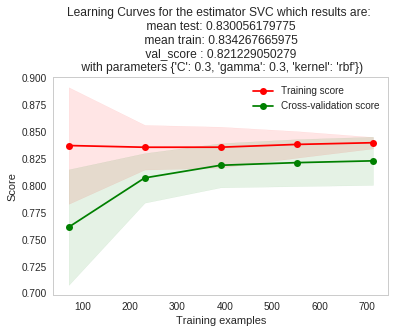

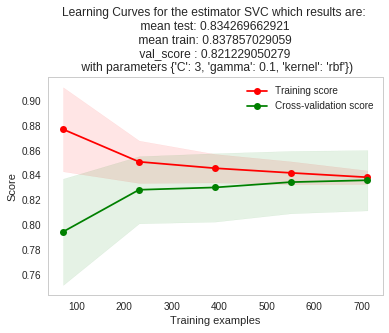

In [62]:
# Learning curve
index = list(df_study_svc.index)
for ind in index :
    
    # Extraction of values
    estim = df_study_svc.loc[ind, 'estimator']
    params = df_study_svc.loc[ind, 'params']
    val_score = df_study_svc.loc[ind, 'val_score']
    mean_test = df_study_svc.loc[ind, 'mean_test_score']
    mean_train = df_study_svc.loc[ind, 'mean_train_score']
    
    # Print the values of the selected model
    title = "Learning Curves for the estimator %s which results are: \n mean test: %s \n mean train: %s \n val_score : %s \n with parameters %s)" % (estim,mean_test,mean_train,val_score,params)
    
    # Build the model
    estimator = models[estim]
    estimator.set_params(**params)
    
    # Split
    cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)
    
    plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=-1)
    plt.show()

Model: SVC
Mean test: 0.830056179775
Mean train: 0.834267665975
Val score: 0.821229050279 
Params: {'C': 0.3, 'gamma': 0.3, 'kernel': 'rbf'}


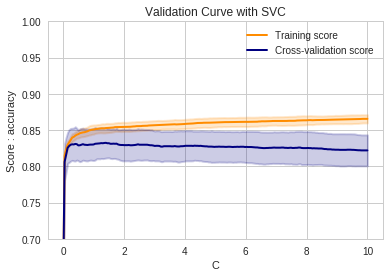

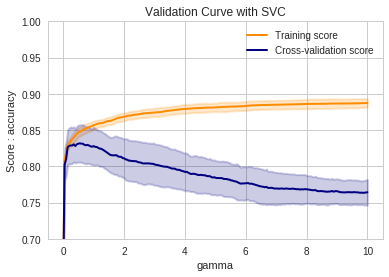

Model: SVC
Mean test: 0.834269662921
Mean train: 0.837857029059
Val score: 0.821229050279 
Params: {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}


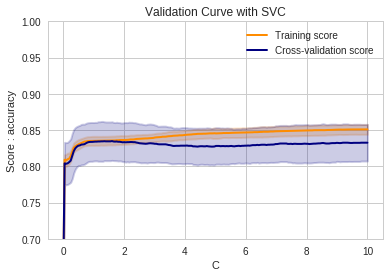

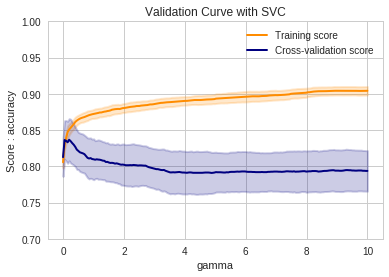

In [63]:
# Validation curve

# Select the model and the ranges of parameters to study
dict_Validation = { 
    'SVC': { 'C': np.linspace(0.001,10,200),
            'gamma' : np.linspace(0.001,10,200)
    }
}

for ind in index :

    # Extraction of values
    estim = df_study_svc.loc[ind, 'estimator']
    params = df_study_svc.loc[ind, 'params']
    mean_test = df_study_svc.loc[ind, 'mean_test_score']
    mean_train = df_study_svc.loc[ind, 'mean_train_score']
    val_score = df_study_svc.loc[ind, 'val_score']
    
    # Print the values of the selected model
    print("Model: %s\nMean test: %s\nMean train: %s\nVal score: %s \nParams: %s" % (estim,mean_test,mean_train,val_score,params))
   
    # Build the model
    estimator = models[estim]
    estimator.set_params(**params)
    
    # Split
    cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)
    
    # Run validation curve
    for key, value in dict_Validation[estim].items():
        plot_validation_curve(estimator, estim, key, value, data, target, scoring='accuracy', cv=cv)
        plt.show()

In [ ]:
# Prediction
svc_params = # Parameters chosen (e.g {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'} )
svc = SVC(**svc_params)
svc.fit(data,target)
svc_pred = svc.predict(test_data)
Prediction['SVC'] = svc_pred

### 8-D Logistic Regression

[[back to top](#Table-of-contents)]

In [64]:
# Pipeline or model setup
models = { 
    'LogisticRegression': LogisticRegression()
}

# Parameters setup
params = { 'LogisticRegression' :  { 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                                   'penalty': ['l1','l2']}
}

# Start grid search
df_best_lr , dic_best_lr, d_res_lr = grid_search_global(dict_pip = models, dict_param = params, scoring ='accuracy',cv=10,
                                            X_train = X_train  ,y_train = y_train, X_test = X_test, y_test = y_test,
                                            verbose = 0)

Starting Gridsearch
Gridsearch Finished


In [65]:
# Filter results
diff = 0.02
std = 0.04
d_res_lr.sort_values(by=['val_score','std_test_score'],ascending=[False,True],inplace=True)
d_res_lr_sort = d_res_lr.loc[(d_res_lr['val_score'] > 0.80) 
              & (d_res_lr['|val-test|'] < diff) 
              & (d_res_lr['|test-train|'] < diff)  
              & (d_res_lr['std_test_score'] < std) 
              & (d_res_lr['std_train_score'] < std)]
display(d_res_lr_sort)

# Take care not to search for too small values because it will certainly lead to overfit to the split of the data

,estimator,val_score,mean_test_score,mean_train_score,std_test_score,std_train_score,|val-test|,|test-train|,val_F_score,val_Precis,val_Recall,val_Confusion,params
13,LogisticRegression,0.826816,0.831461,0.839730,0.034983,0.004304,0.004645,0.008269,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 1, 'penalty': 'l2'}"
15,LogisticRegression,0.826816,0.835674,0.840823,0.035127,0.004462,0.008859,0.005148,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 3, 'penalty': 'l2'}"
17,LogisticRegression,0.826816,0.832865,0.840666,0.036490,0.004241,0.006050,0.007800,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 10, 'penalty': 'l2'}"
16,LogisticRegression,0.826816,0.832865,0.839260,0.036490,0.004786,0.006050,0.006395,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 10, 'penalty': 'l1'}"
11,LogisticRegression,0.826816,0.823034,0.833019,0.036690,0.005096,0.003782,0.009986,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 0.3, 'penalty': 'l2'}"
18,LogisticRegression,0.826816,0.831461,0.839574,0.036901,0.004455,0.004645,0.008113,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 30, 'penalty': 'l1'}"
19,LogisticRegression,0.826816,0.831461,0.839418,0.036901,0.004812,0.004645,0.007957,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 30, 'penalty': 'l2'}"
20,LogisticRegression,0.826816,0.831461,0.839730,0.036901,0.004525,0.004645,0.008269,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 100, 'penalty': 'l1'}"
21,LogisticRegression,0.826816,0.831461,0.839730,0.036901,0.004525,0.004645,0.008269,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 100, 'penalty': 'l2'}"
12,LogisticRegression,0.826816,0.831461,0.838949,0.038383,0.004790,0.004645,0.007489,0.766917,0.796875,0.73913,[[97 13]\n [18 51]],"{'C': 1, 'penalty': 'l1'}"


In [66]:
# Selection of the parameters to study
index_selection_lr = [13, 16]
df_study_lr = d_res_lr.loc[index_selection_lr,['estimator','params','val_score','mean_test_score','mean_train_score','val_F_score']]
df_study_lr.reset_index(inplace=True)
display(df_study_lr)

,index,estimator,params,val_score,mean_test_score,mean_train_score,val_F_score
0,13,LogisticRegression,"{'C': 1, 'penalty': 'l2'}",0.826816,0.831461,0.83973,0.766917
1,16,LogisticRegression,"{'C': 10, 'penalty': 'l1'}",0.826816,0.832865,0.83926,0.766917


In [ ]:
# Enbale to set specific values if needed for testing learning and validation curve
df_study_lr.set_value(1,'params',{'C': 1, 'penalty': 'l1'})
df_study_lr.set_value(1,'params',{'C': 1, 'penalty': 'l2'})

# Put 0 for scores
zeros =  np.zeros((df_study_gbc.shape[0],4))
df_study_lr[['val_score','mean_test_score','mean_train_score','val_F_score']] = zeros

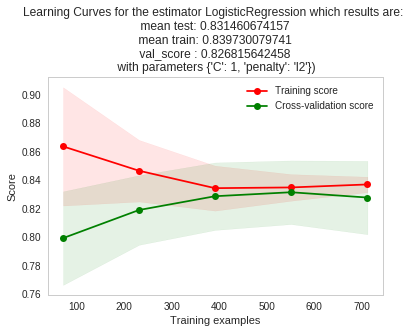

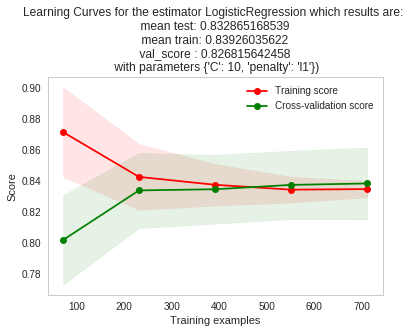

In [67]:
# Learning curve
index = list(df_study_lr.index)

for ind in index :
    
    # Extraction of values
    estim = df_study_lr.loc[ind, 'estimator']
    params = df_study_lr.loc[ind, 'params']
    val_score = df_study_lr.loc[ind, 'val_score']
    mean_test = df_study_lr.loc[ind, 'mean_test_score']
    mean_train = df_study_lr.loc[ind, 'mean_train_score']
    
    # Print the values of the selected model
    title = "Learning Curves for the estimator %s which results are: \n mean test: %s \n mean train: %s \n val_score : %s \n with parameters %s)" % (estim,mean_test,mean_train,val_score,params)
    
    # Build the model
    estimator = models[estim]
    estimator.set_params(**params)
    
    # Split
    cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)
    
    plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=-1)
    plt.show()

Model: LogisticRegression
Mean test: 0.831460674157
Mean train: 0.839730079741
Val score: 0.826815642458 
Params: {'C': 1, 'penalty': 'l2'}


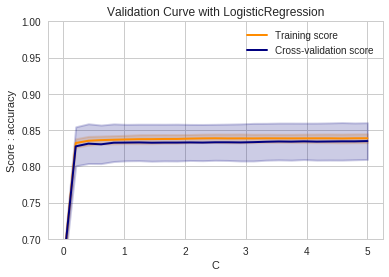

Model: LogisticRegression
Mean test: 0.832865168539
Mean train: 0.83926035622
Val score: 0.826815642458 
Params: {'C': 10, 'penalty': 'l1'}


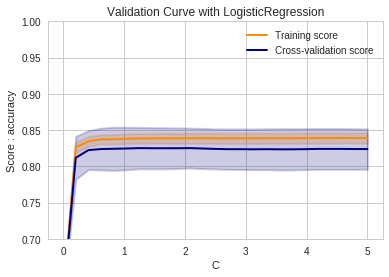

In [69]:
# Validation curve

# Select the model and the ranges of parameters to study
dict_Validation = { 
    'LogisticRegression': { 'C': np.linspace(0.001,5,25)
    }
}
for ind in index :
 
    # Extraction of values
    estim = df_study_lr.loc[ind, 'estimator']
    params = df_study_lr.loc[ind, 'params']
    mean_test = df_study_lr.loc[ind, 'mean_test_score']
    mean_train = df_study_lr.loc[ind, 'mean_train_score']
    val_score = df_study_lr.loc[ind, 'val_score']
    
    # Print the values of the selected model
    print("Model: %s\nMean test: %s\nMean train: %s\nVal score: %s \nParams: %s" % (estim,mean_test,mean_train,val_score,params))
    
    # Build the model
    estimator = models[estim]
    estimator.set_params(**params)
    
    # Split    
    cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)
    
    # Run validation curve
    for key, value in dict_Validation[estim].items():
        plot_validation_curve(estimator, estim, key, value, data, target, scoring='accuracy', cv=cv)
        plt.show()

In [ ]:
# Prediction
lr_params = # Parmeters chosen (e.g {'C': 10, 'penalty': 'l1'} )
lr = LogisticRegression(**lr_params)
lr.fit(data,target)
lr_pred = lr.predict(test_data)
Prediction['LR'] = lr_pred

### 8-E Random Forest

[[back to top](#Table-of-contents)]

In [70]:
# Pipeline or model setup
models = { 
    'RandomForestClassifier': RandomForestClassifier(),
}

# Parameters setup
params = {
    'RandomForestClassifier': { 'n_estimators': [10,30,100],
                               'criterion' : ['gini','entropy'],
                               'max_features': [2,3,4,5],
                               'max_depth': [3,5,7],
                               'min_samples_split': [2,3,5],
                               'min_samples_leaf':  [2,3,5]
                              }
}

# Start grid search
df_best_rf, dic_best_rf, d_res_rf =grid_search_global(dict_pip = models, dict_param = params, scoring ='accuracy',cv=10,
                                            X_train = X_train  ,y_train = y_train, X_test = X_test, y_test = y_test,
                                            verbose = 0)

Starting Gridsearch
Gridsearch Finished


In [71]:
# Filter results
diff = 0.02
std = 0.04
d_res_rf.sort_values(by=['val_score','std_test_score'],ascending=[False,True],inplace=True)
d_res_rf_sort = d_res_rf.loc[(d_res_rf['val_score'] > 0.80) 
              & (d_res_rf['|val-test|'] < diff) 
              & (d_res_rf['|test-train|'] < diff)  
              & (d_res_rf['std_test_score'] < std) 
              & (d_res_rf['std_train_score'] < std)]
display(d_res_rf_sort)

,estimator,val_score,mean_test_score,mean_train_score,std_test_score,std_train_score,|val-test|,|test-train|,val_F_score,val_Precis,val_Recall,val_Confusion,params
33,RandomForestClassifier,0.826816,0.810393,0.815536,0.023875,0.012381,0.016422,0.005143,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}"
411,RandomForestClassifier,0.826816,0.818820,0.824121,0.024956,0.011045,0.007995,0.005301,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}"
339,RandomForestClassifier,0.826816,0.810393,0.815543,0.025415,0.012942,0.016422,0.005150,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}"
428,RandomForestClassifier,0.826816,0.816011,0.829274,0.026054,0.010699,0.010804,0.013262,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}"
415,RandomForestClassifier,0.826816,0.811798,0.830522,0.027142,0.010831,0.015018,0.018725,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}"
439,RandomForestClassifier,0.826816,0.837079,0.848312,0.027247,0.009245,0.010263,0.011233,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 30}"
262,RandomForestClassifier,0.826816,0.832865,0.851119,0.028004,0.005916,0.006050,0.018254,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'gini', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 30}"
441,RandomForestClassifier,0.826816,0.830056,0.840196,0.028110,0.009383,0.003241,0.010139,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}"
537,RandomForestClassifier,0.826816,0.831461,0.847848,0.028540,0.006459,0.004645,0.016387,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}"
40,RandomForestClassifier,0.826816,0.808989,0.819758,0.028625,0.015197,0.017827,0.010770,0.752,0.839286,0.681159,[[101 9]\n [ 22 47]],"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 30}"


In [72]:
# Selection of the parameters to study
index_selection_rf = [33, 411]
df_study_rf = d_res_rf.loc[index_selection_rf,['estimator','params','val_score','mean_test_score','mean_train_score','val_F_score']]
df_study_rf.reset_index(inplace=True)
display(df_study_rf)

,index,estimator,params,val_score,mean_test_score,mean_train_score,val_F_score
0,33,RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}",0.826816,0.810393,0.815536,0.752
1,411,RandomForestClassifier,"{'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}",0.826816,0.818820,0.824121,0.752


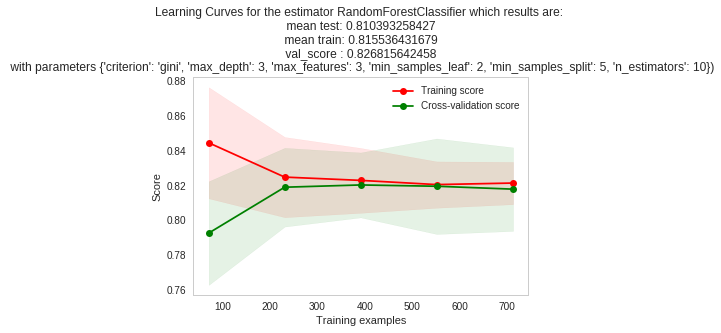

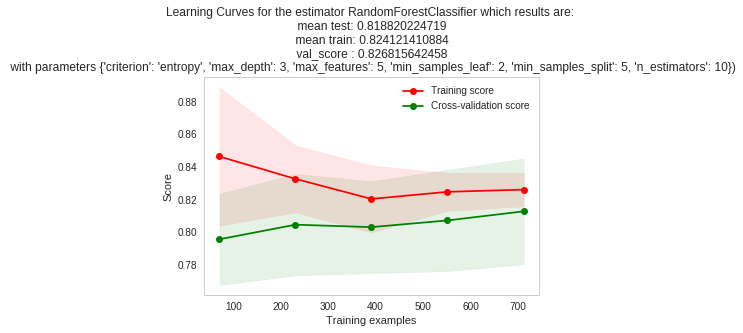

In [73]:
# Learning curve

index = list(df_study_rf.index)

for ind in index :
    
    # Extraction of values
    estim = df_study_rf.loc[ind, 'estimator']
    params = df_study_rf.loc[ind, 'params']
    val_score = df_study_rf.loc[ind, 'val_score']
    mean_test = df_study_rf.loc[ind, 'mean_test_score']
    mean_train = df_study_rf.loc[ind, 'mean_train_score']
    
    # Print the values of the selected model    
    title = "Learning Curves for the estimator %s which results are: \n mean test: %s \n mean train: %s \n val_score : %s \n with parameters %s)" % (estim,mean_test,mean_train,val_score,params)

    # Build the model
    estimator = models[estim]
    estimator.set_params(**params)
    
    # Split    
    cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)
    
    plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=-1)
    plt.show()

Model: RandomForestClassifier
Mean test: 0.810393258427
Mean train: 0.815536431679
Val score: 0.826815642458 
Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}


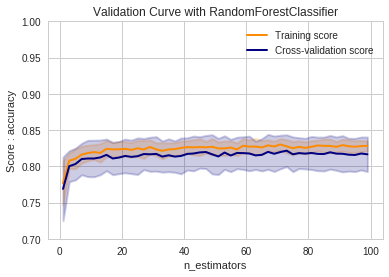

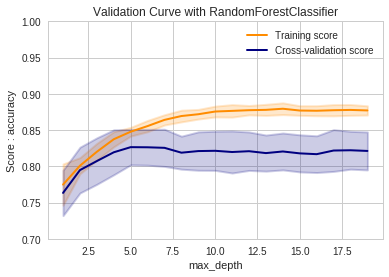

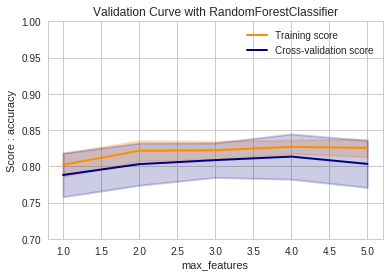

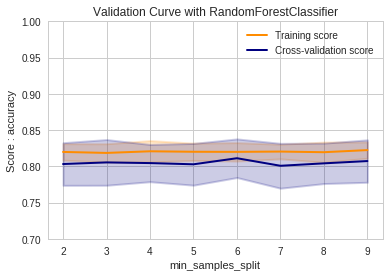

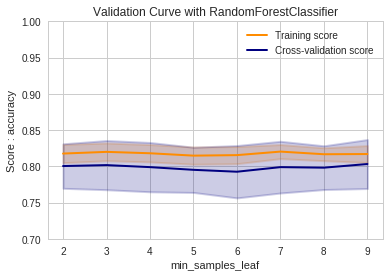

Model: RandomForestClassifier
Mean test: 0.818820224719
Mean train: 0.824121410884
Val score: 0.826815642458 
Params: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}


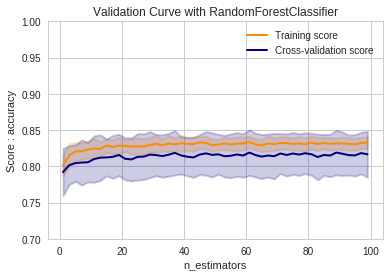

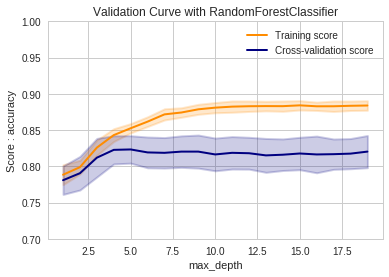

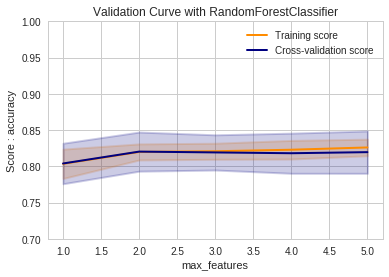

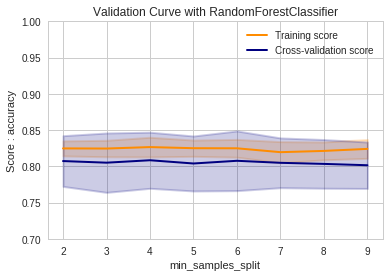

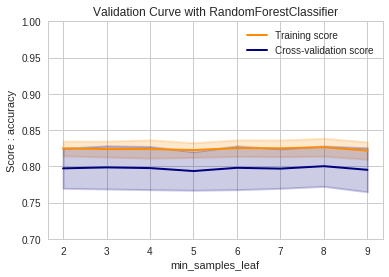

In [74]:
# Validation curve

# Select the model and the ranges of parameters to study
dict_Validation = { 
    'RandomForestClassifier': {'n_estimators': range(1,100,2),
                               'max_depth' : range(1,20,1),
                               'max_features':range(1,6,1),
                               'min_samples_split': range(2,10,1),
                               'min_samples_leaf': range(2,10,1)}  
}

for ind in index :

    # Extraction of values
    estim = df_study_rf.loc[ind, 'estimator']
    params = df_study_rf.loc[ind, 'params']
    mean_test = df_study_rf.loc[ind, 'mean_test_score']
    mean_train = df_study_rf.loc[ind, 'mean_train_score']
    val_score = df_study_rf.loc[ind, 'val_score']
    
    # Print the values of the selected model
    print("Model: %s\nMean test: %s\nMean train: %s\nVal score: %s \nParams: %s" % (estim,mean_test,mean_train,val_score,params))
    
    # Build the model
    estimator = models[estim]
    estimator.set_params(**params)
    
    # Split
    cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2)

    # Run validation curve
    for key, value in dict_Validation[estim].items():
        plot_validation_curve(estimator, estim, key, value, data, target, scoring='accuracy', cv=cv)
        plt.show()

In [ ]:
# Prediction 
RF_params =  # Parmeters chosen (e.g {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 10})
rf = RandomForestClassifier(**RF_params)
rf.fit(data,target)
rf_pred = rf.predict(test_data)
Prediction['RF'] = rf_pred

## 9 - Submission

[[back to top](#Table-of-contents)]

In [ ]:
# Choose the prediction to submit and comment the others

Predic = Prediction['SVC']
#Predic = Prediction['LR']
#Predic = Prediction['RF']

In [ ]:
# Save into a csv to submit
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": Predic
    })
submission.to_csv('titanic_pred.csv', index=False)